<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')
sns.set(rc={"figure.figsize": (15, 8)})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:left;padding:8px;">



<p>
<span style="color:green;font-size:14pt"><b>Data Cleaning</span></b>
<br>
<br><b>Step 1:</b> Remove all non-residential houses
<br><b>Step 2:</b> Identify fixed features that can predict price
<br><b>Step 3:</b> Impute NaN values to -99
<br><b>Step 4:</b> Standardise all numeric values
<br><b>Step 5:</b> Binarise year and month
<br><b>Step 6:</b> Get dummy variables for all descriptive values
</p>
<p><br>
<span style="color:green;font-size:14pt"><b>Feature Selection</span></b>
<br>
<br>Use ANOVA on categorical features (target is continuous)
<br>Use Pearson on continuous features
<br>Use LassoCV as a wrapper

</div>

In [2]:
# Load the data_description

with open('./data_description.txt') as f:
    content = f.readlines()
    
    for x in content:
        print x
    

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES

        80	SPLIT OR MULTI-LEVEL

        85	SPLIT FOYER

        90	DUPLEX - ALL STYLES AND AGES

       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER

       150	1-1/2 STORY PUD - ALL AGES

       160	2-STORY PUD - 1946 & NEWER

       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER

       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



MSZoning: Identifies the general zoning classification of the sale.

		

       A	Agriculture

       C	Commercial

       FV	Floating Village Residential

       I	Industrial

       RH	Residential High Density

       RL	Residential Low Density

       RP	Residential 

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

# Remove all houses that are not residential
house = house[~house.MSZoning.isin(['A','C','FV','I'])]
house.reset_index(inplace=True,drop=True)

In [4]:
class Cleaner(object):
    def __init__(self,csv_data):
        
        self.csv_data = csv_data
        self.head = csv_data.head()
        self.info = csv_data.info() 
        self.nan = csv_data.isnull().sum()
        self.columns = csv_data.columns
        
            
    def check(self):
        
        #print 'Check info:',self.csv_data.info() 
        print 'Check NaN:',self.csv_data.isnull().sum()
        print 'Check columns:',self.csv_data.columns
        
        for col in self.csv_data.columns:
            print col,' unique values:',self.csv_data[col].nunique()
            
        return self.csv_data.head()
    
    def drop_columns(self,columns,inplace=True):
        """columns to drop in a list, inplace = True"""
        
        self.csv_data.drop(columns,axis=1,inplace=inplace)
        
        return self.csv_data.head(3)

In [5]:
# Check data

cleaner = Cleaner(house)
cleaner.check()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 81 columns):
Id               1395 non-null int64
MSSubClass       1395 non-null int64
MSZoning         1395 non-null object
LotFrontage      1144 non-null float64
LotArea          1395 non-null int64
Street           1395 non-null object
Alley            67 non-null object
LotShape         1395 non-null object
LandContour      1395 non-null object
Utilities        1395 non-null object
LotConfig        1395 non-null object
LandSlope        1395 non-null object
Neighborhood     1395 non-null object
Condition1       1395 non-null object
Condition2       1395 non-null object
BldgType         1395 non-null object
HouseStyle       1395 non-null object
OverallQual      1395 non-null int64
OverallCond      1395 non-null int64
YearBuilt        1395 non-null int64
YearRemodAdd     1395 non-null int64
RoofStyle        1395 non-null object
RoofMatl         1395 non-null object
Exterior1st      1395 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
drop_col = ['FireplaceQu','PoolQC','Fence','Alley','MiscFeature','Id'] # drop column - too little values
cleaner.drop_columns(drop_col)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500


In [7]:
drop_col2 = ['Fireplaces','PoolArea'] # drop column - most house do not have pool/fireplace
cleaner.drop_columns(drop_col2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,9,2008,WD,Normal,223500


In [8]:
# Identify fixed features based on metadata

fixed_col = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','LotShape','LandContour','LotConfig',
'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd','BsmtQual',
'BsmtExposure','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','2ndFlrSF','BsmtFullBath','BsmtHalfBath',
'FullBath','HalfBath','TotRmsAbvGrd','GarageType','GarageYrBlt','GarageCars','GarageArea','PavedDrive',
'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal','MoSold',
'YrSold','SaleType','SaleCondition','SalePrice']

In [9]:
fixed = house[fixed_col]

In [10]:
# Separate the data into categorical vs continous

continous = []
categorical = []
tt_split = []
y = []

for col in fixed.columns:
    if col == 'SalePrice':
        y.append(col)
    elif col == 'YrSold':
        tt_split.append(col)
    elif col in ['MoSold','YearBuilt','YearRemodAdd','GarageYrBlt']:
        categorical.append(col)
    elif fixed[col].dtype != object:
        continous.append(col)
    else:
        categorical.append(col)


# CATEGORICAL

In [11]:
fixed[categorical].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 21 columns):
MSZoning         1395 non-null object
Street           1395 non-null object
LotShape         1395 non-null object
LandContour      1395 non-null object
LotConfig        1395 non-null object
LandSlope        1395 non-null object
Neighborhood     1395 non-null object
Condition1       1395 non-null object
Condition2       1395 non-null object
BldgType         1395 non-null object
HouseStyle       1395 non-null object
YearBuilt        1395 non-null int64
YearRemodAdd     1395 non-null int64
BsmtQual         1358 non-null object
BsmtExposure     1357 non-null object
GarageType       1314 non-null object
GarageYrBlt      1314 non-null float64
PavedDrive       1395 non-null object
MoSold           1395 non-null int64
SaleType         1395 non-null object
SaleCondition    1395 non-null object
dtypes: float64(1), int64(3), object(17)
memory usage: 228.9+ KB


In [12]:
# fill NaN values with 'None'

fixed['BsmtQual'].fillna('None',inplace=True)
fixed['BsmtExposure'].fillna('None',inplace=True)
fixed['GarageType'].fillna('None',inplace=True)
fixed['GarageYrBlt'].fillna('None',inplace=True)

/Users/joannasyeow/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


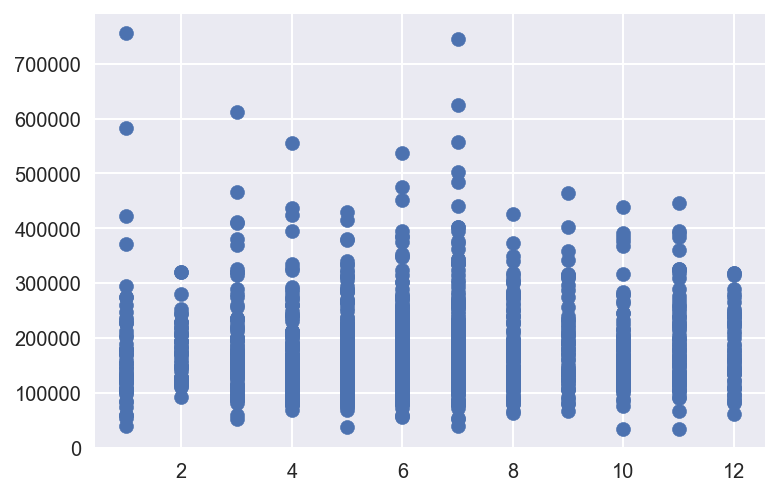

In [13]:
plt.scatter(fixed['MoSold'],fixed[y])

<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:center;padding:8px;">

<p>Since there isn't any linearity between month and target variable, month sold will be considered as categorical.</p>

</div> 

In [14]:
# bin month in quarters

def bin_mth(x):
    
    if x in ['None']:
        x = x
    if x in [1,2,3]:
        x = 'q1'
    elif x in [4,5,6]:
        x = 'q2'
    elif x in [7,8,9]:
        x = 'q3'
    else:
        x = 'q4'
        
    return x

In [15]:
fixed.MoSold = fixed.MoSold.map(bin_mth)

/Users/joannasyeow/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


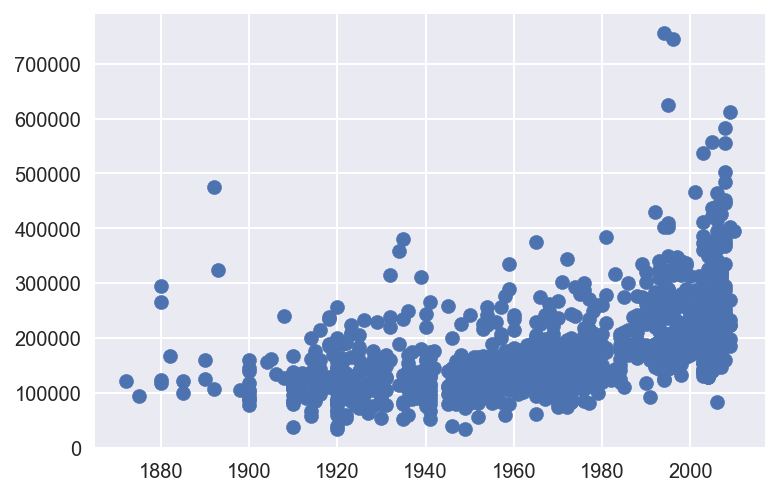

In [16]:
plt.scatter(fixed['YearBuilt'],fixed[y])

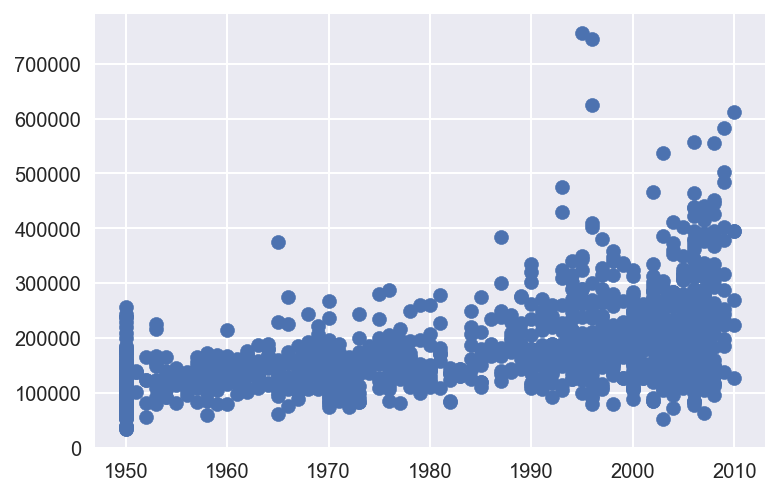

In [17]:
plt.scatter(fixed['YearRemodAdd'],fixed[y])

<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:center;padding:8px;">

<p>There isn't a very strong linearity relationship between year sold and target variable. Decide to use it as a categorial variable.</p>

</div> 

In [18]:
# bin year

def bin_year(x):
    
    if x in ['None']:
        x = x
        
    elif x < 1950:
        x = '1940s'
        
    elif x < 1960:
        x = '1950s'
        
    elif x < 1970:
        x = '1960s'
        
    elif x < 1980:
        x = '1970s'
        
    elif x < 1990:
        x = '1980s'
        
    elif x < 2000:
        x = '1990s'
        
    else:
        x = '2000s'
    
    return x

In [19]:
fixed['YearBuilt'] = fixed['YearBuilt'].map(bin_year)
fixed['YearRemodAdd'] = fixed['YearRemodAdd'].map(bin_year)
fixed['GarageYrBlt'] = fixed['GarageYrBlt'].map(bin_year)

/Users/joannasyeow/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/joannasyeow/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/joannasyeow/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [20]:
# Get dummies for categorical data

fixed[categorical] = fixed[categorical].astype(str)
cate_dummies = pd.get_dummies(fixed[categorical],drop_first=False)

fixed = fixed.merge(cate_dummies,left_index=True, right_index=True)  # merge dummies
fixed.drop(fixed[categorical],axis=1,inplace=True)

/Users/joannasyeow/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [21]:
# Filter: ANOVA

#from sklearn.feature_selection import SelectKBest, chi2, f_classif

# build the selector
#skb_f = SelectKBest(f_classif, k='all')
#skb_f.fit(cate_dummies, fixed[y])
#kbest = pd.DataFrame([cate_dummies.columns, list(skb_f.pvalues_)], 
 #                    index=['feature','f_classif']).T.sort_values('f_classif', ascending=False)

#kbest

In [22]:
#remove = list(kbest[kbest.f_classif>0.05]['feature'])  # At 95% significance level
#print fixed[remove].columns

#fixed.drop(fixed[remove],axis=1,inplace=True)  # drop features

# CONTINUOUS

In [23]:
fixed[continous].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 21 columns):
MSSubClass       1395 non-null int64
LotFrontage      1144 non-null float64
LotArea          1395 non-null int64
BsmtFinSF1       1395 non-null int64
BsmtFinSF2       1395 non-null int64
TotalBsmtSF      1395 non-null int64
1stFlrSF         1395 non-null int64
2ndFlrSF         1395 non-null int64
BsmtFullBath     1395 non-null int64
BsmtHalfBath     1395 non-null int64
FullBath         1395 non-null int64
HalfBath         1395 non-null int64
TotRmsAbvGrd     1395 non-null int64
GarageCars       1395 non-null int64
GarageArea       1395 non-null int64
WoodDeckSF       1395 non-null int64
OpenPorchSF      1395 non-null int64
EnclosedPorch    1395 non-null int64
3SsnPorch        1395 non-null int64
ScreenPorch      1395 non-null int64
MiscVal          1395 non-null int64
dtypes: float64(1), int64(20)
memory usage: 228.9 KB


In [24]:
fixed['LotFrontage'].fillna(-99.0,inplace=True)  # Fill NaN as -99

In [25]:
# Scale numeric columns

from sklearn.preprocessing import StandardScaler

scale = StandardScaler(copy=False)
fixed[continous] = scale.fit_transform(fixed[continous])

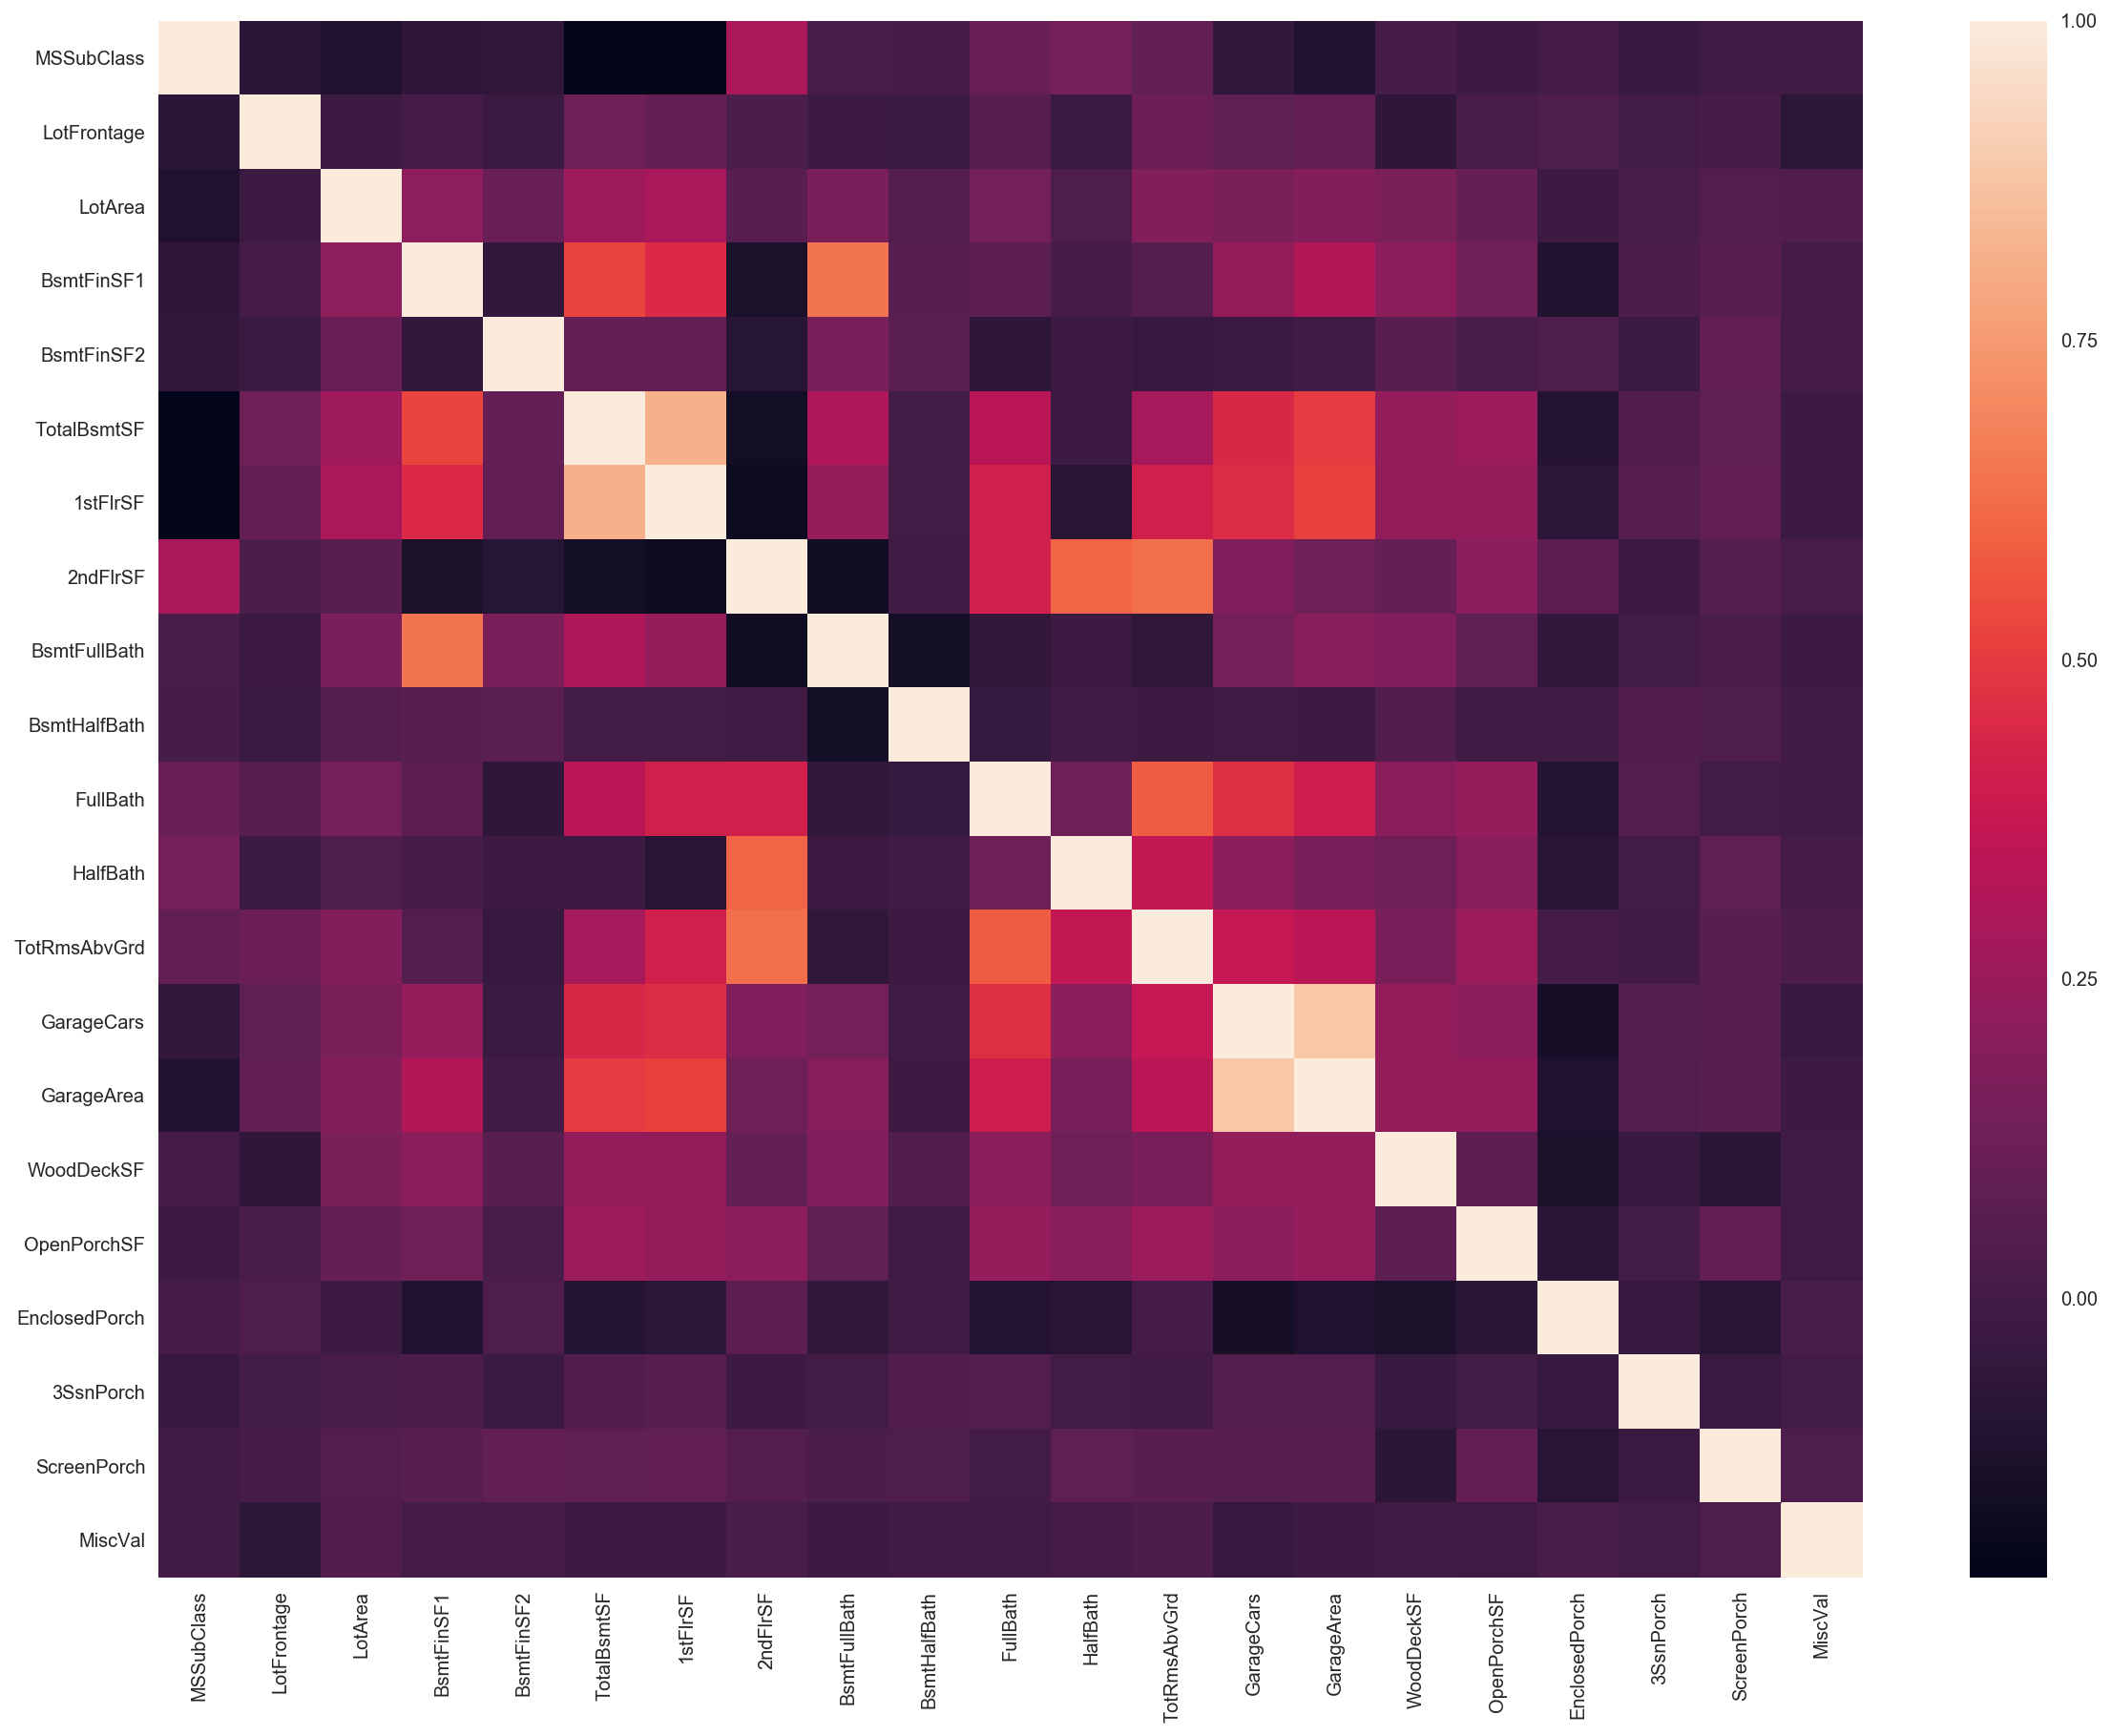

In [26]:
# Filter: Pearson

sns.set(rc={"figure.figsize": (20, 15)})
corr_con = fixed[continous].corr()
sns.heatmap(corr_con)

In [27]:
# Identify correlation > 0.5 (threshold)

pd.set_option('display.max_columns', 50)
corr_con[corr_con >= 0.5]

,MSSubClass,LotFrontage,LotArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
MSSubClass,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinSF1,NaN,NaN,NaN,1.000000,NaN,0.528631,NaN,NaN,0.645072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinSF2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalBsmtSF,NaN,NaN,NaN,0.528631,NaN,1.000000,0.815856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500270,NaN,NaN,NaN,NaN,NaN,NaN
1stFlrSF,NaN,NaN,NaN,NaN,NaN,0.815856,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.514228,NaN,NaN,NaN,NaN,NaN,NaN
2ndFlrSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.601003,0.632938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFullBath,NaN,NaN,NaN,0.645072,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtHalfBath,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
fixed.drop(['BsmtFinSF1','1stFlrSF','GarageArea','HalfBath','TotRmsAbvGrd'],axis=1,inplace=True)  # drop features

In [29]:
# split data into train and test

test_data = fixed[fixed['YrSold'] >= 2010]
train_data = fixed[fixed['YrSold']<2010]

print test_data.shape
print train_data.shape

(167, 155)
(1228, 155)


In [30]:
from sklearn.linear_model import ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import metrics

# Identify X ,y
X_train = train_data.drop(['SalePrice','YrSold'],axis=1)
y_train = train_data['SalePrice']

X_test = test_data.drop(['SalePrice','YrSold'],axis=1)
y_test = test_data['SalePrice']


In [31]:
# Feature selection with LassoCV

# select the best alpha with LassoCV
from sklearn.linear_model import LassoCV
lassoregcv = LassoCV(n_alphas=100, normalize=True, random_state=1,cv=5)
lassoregcv.fit(X_train, y_train)

y_pred = lassoregcv.predict(X_test)

# examine the coefficients
print 'coef:',lassoregcv.coef_
print 'R2:',lassoregcv.score(X_test, y_test)
print 'mean_sq_error:',np.sqrt(metrics.mean_squared_error(y_test, y_pred))

coef: [  -926.28419078     -0.           3573.25847938     -0.          19631.30867303
  17282.32612117   3466.19449945      0.           7741.53462443
  13045.27172058   3066.20682749    238.65742198     -0.            933.46456983
   3376.29767639     -0.         -24475.19592112      0.           5256.70691741
     -0.             -0.              0.              0.           8684.97442073
 -22071.42924344     -0.          -1736.20681816      0.             -0.
      0.              0.           4940.67974144 -10762.95300174
  -1972.67501368     -0.             -0.              0.          -3964.89995809
      0.             -0.              0.              0.             -0.
      0.          29854.67211629 -12207.74049944  -2441.02553321     -0.
     -0.          -9509.3958313      -0.             -0.              0.
  70079.63476379  44296.2502086   -5183.05294604     -0.             -0.
   1790.25283434  13611.30219758  57528.68452659      0.          20475.46805442
     -0.     

In [32]:
# Remove columns with 0 lasso_coef

coef = list(lassoregcv.coef_)
new_col = []
for ind,num in enumerate(coef):
    if num != 0.0 or num != -0.0:
        new_col.append(ind)
        
newX_train = X_train.iloc[:,new_col]
newy_train = y_train

newX_test = X_test.iloc[:,new_col]
newy_test = y_test

In [33]:
# RidgeCV

ridgeregcv = RidgeCV(normalize=False,alphas=np.linspace(0.01, 100, 100))
ridgeregcv.fit(newX_train, newy_train)

# predict method with the best alpha value
newy_pred = ridgeregcv.predict(newX_test)

print 'coefficients: ',ridgeregcv.coef_
print 'R2: ',ridgeregcv.score(newX_test, newy_test)
print 'mean_sq_error: ',np.sqrt(metrics.mean_squared_error(newy_test, newy_pred))
print ridgeregcv.alpha_

coefficients:  [ -4940.07248173   4480.75717816  20505.66112835  20662.25058539
   4874.60834832   7168.95782616  11995.50176724   3695.56121507
    477.09480422   2188.78689642   4258.17561075 -19452.67530956
   6154.39106167  10517.81785163 -22858.78528708  -7252.93345285
   8434.00457272 -13797.13241945  -8096.28324576 -17367.01724145
  29750.58407361 -17685.36551652 -11537.05125408 -15157.16818423
  57360.49918003  40295.44193089  -6965.79922036   3631.99504543
  16011.7572377   46578.34049624  20461.6754431   -6793.73785129
   5334.79283761   9235.1184968   14338.88033793 -30021.80402298
   7414.02053481 -10608.96483621  12086.59058558   3928.45124913
  -3489.41324364  -7523.94972767  12481.3199453   11082.86645593
  45178.96431667  -4056.80488393  17723.43892483   -333.71533012
  20195.45783954  -9450.28290458 -21488.17267819   4191.60709489
  -9935.29705066  -7795.49038222   4688.73105878  -4190.0553539
  10645.53736891  12489.23522185  -5630.50691717  11128.05265615]
R2:  0.851

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:center;padding:8px;">

<span style="color:black">

<p>

<b> Business Model </b>
<br>1. Buy houses at lower price (due to renovate-able features)
<br>2. Renovate the house at rock-bottom price(Assumption)
<br>3. Sell the house at market rate = PROFIT

<br>

<br> <b>What are the renovable featured that affects my sale price?</b>
<br>1. Check for correlation with variance, choose the feature that has an effect on sale price
<br> 2. If correlated, the particular feature has an effect in the sale price
<br> 3. which means that my company can renovate that particular feature to increase sale price
<br>
<br>model 1 predict price based on fixed features
<br>model 2 predict change in price of renovate-able features
<br>model 1 + model 2 = predicted sale price = predicted revenue

</p>

</div>

In [34]:
# slice renovate-able columns

renovable_col = house.columns[~house.columns.isin(fixed_col)]
renovable = house.filter(items=renovable_col)
renovable['YrSold']=house['YrSold']

In [35]:
# Obtain the residuals using selected model on all rows

all_X = newX_train.append(newX_test)
all_y_pred = ridgeregcv.predict(all_X)  # yhat

In [36]:
var = all_y_pred - np.array(house['SalePrice'])   # yhat - y
renovable['var'] = var

In [37]:
renovable.head()

,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,YrSold,var
0,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,TA,GLQ,Unf,150,GasA,Ex,Y,SBrkr,0,1710,3,1,Gd,Typ,RFn,TA,TA,2008,-5505.770137
1,AllPub,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,ALQ,Unf,284,GasA,Ex,Y,SBrkr,0,1262,3,1,TA,Typ,RFn,TA,TA,2007,17337.714633
2,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,TA,GLQ,Unf,434,GasA,Ex,Y,SBrkr,0,1786,3,1,Gd,Typ,RFn,TA,TA,2008,-2238.185439
3,AllPub,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,Gd,ALQ,Unf,540,GasA,Gd,Y,SBrkr,0,1717,3,1,Gd,Typ,Unf,TA,TA,2006,56657.252581
4,AllPub,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,TA,GLQ,Unf,490,GasA,Ex,Y,SBrkr,0,2198,4,1,Gd,Typ,RFn,TA,TA,2008,57196.734528


In [38]:
for col in renovable.columns:
    print col, renovable[col].nunique()

Utilities 2
OverallQual 10
OverallCond 9
RoofStyle 6
RoofMatl 8
Exterior1st 15
Exterior2nd 16
MasVnrType 4
MasVnrArea 320
ExterQual 4
ExterCond 5
Foundation 6
BsmtCond 4
BsmtFinType1 6
BsmtFinType2 6
BsmtUnfSF 760
Heating 6
HeatingQC 5
CentralAir 2
Electrical 5
LowQualFinSF 23
GrLivArea 835
BedroomAbvGr 8
KitchenAbvGr 4
KitchenQual 4
Functional 7
GarageFinish 3
GarageQual 5
GarageCond 5
YrSold 5
var 1395


In [39]:
renovable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 31 columns):
Utilities       1395 non-null object
OverallQual     1395 non-null int64
OverallCond     1395 non-null int64
RoofStyle       1395 non-null object
RoofMatl        1395 non-null object
Exterior1st     1395 non-null object
Exterior2nd     1395 non-null object
MasVnrType      1390 non-null object
MasVnrArea      1390 non-null float64
ExterQual       1395 non-null object
ExterCond       1395 non-null object
Foundation      1395 non-null object
BsmtCond        1358 non-null object
BsmtFinType1    1358 non-null object
BsmtFinType2    1357 non-null object
BsmtUnfSF       1395 non-null int64
Heating         1395 non-null object
HeatingQC       1395 non-null object
CentralAir      1395 non-null object
Electrical      1394 non-null object
LowQualFinSF    1395 non-null int64
GrLivArea       1395 non-null int64
BedroomAbvGr    1395 non-null int64
KitchenAbvGr    1395 non-null int64
KitchenQual

In [40]:
renovable.Electrical.fillna('SBrkr',inplace=True)  # impute with mode 

In [41]:
renovable.MasVnrType.fillna('None',inplace=True)   # impute with 'None'

In [42]:
# impute NaN value as -99

renovable['MasVnrArea'].fillna(-99,inplace=True)

In [43]:
# Separate the data into categorical vs continuous - masking

cont = []
cat = []
y = []

for col in renovable.columns:
    if col == 'var':
        y.append(col)
    elif renovable[col].dtype != object:
        cont.append(col)
    else:
        cat.append(col)


## CONTINUOUS

In [44]:
renovable[cont].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 9 columns):
OverallQual     1395 non-null int64
OverallCond     1395 non-null int64
MasVnrArea      1395 non-null float64
BsmtUnfSF       1395 non-null int64
LowQualFinSF    1395 non-null int64
GrLivArea       1395 non-null int64
BedroomAbvGr    1395 non-null int64
KitchenAbvGr    1395 non-null int64
YrSold          1395 non-null int64
dtypes: float64(1), int64(8)
memory usage: 98.2 KB


<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:center;padding:8px;">

<span style="color:black">

<p>
<b>Rank-Hot-Encoder</b>
In this dataset, many of the features are rankings. Even though they are numerical, it wouldn't make sense to treat them as continuous variables as adding/subtracting or multipying the variables are not meaningful.
<br><br>
However, if they are treated as categorical data by using dummy variables, we are losing out the meaningful ranking structure. I did some research and came across a blog that suggested the'rank-hot-encoder' method, which i have decided to try it out.
<br>
http://scottclowe.com/2016-03-05-rank-hot-encoder/

<br><br>
One-hot-encoding tells us whether it is a '1' or 'not a 1'
<br>
Rank-hot-encoding tells us whether it is 'at least a 1' or 'not at least a 1'

<br><br>

<table>
  <thead>
    <tr>
      <th>Ranking</th>
      <th>Rank Index</th>
      <th>One-Hot Encoding</th>
      <th>Rank-Hot Encoding</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Poor</td>
      <td>0</td>
      <td><code class="highlighter-rouge">[1, 0, 0, 0, 0]</code></td>
      <td><code class="highlighter-rouge">[0, 0, 0, 0]</code></td>
    </tr>
    <tr>
      <td>Fair</td>
      <td>1</td>
      <td><code class="highlighter-rouge">[0, 1, 0, 0, 0]</code></td>
      <td><code class="highlighter-rouge">[1, 0, 0, 0]</code></td>
    </tr>
    <tr>
      <td>Average</td>
      <td>2</td>
      <td><code class="highlighter-rouge">[0, 0, 1, 0, 0]</code></td>
      <td><code class="highlighter-rouge">[1, 1, 0, 0]</code></td>
    </tr>
    <tr>
      <td>Good</td>
      <td>3</td>
      <td><code class="highlighter-rouge">[0, 0, 0, 1, 0]</code></td>
      <td><code class="highlighter-rouge">[1, 1, 1, 0]</code></td>
    </tr>
    <tr>
      <td>Excellent</td>
      <td>4</td>
      <td><code class="highlighter-rouge">[0, 0, 0, 0, 1]</code></td>
      <td><code class="highlighter-rouge">[1, 1, 1, 1]</code></td>
    </tr>
  </tbody>
</table>
</p>
<p>
<br>
'rank-hot-encoder' is more meaningful in this project because it is necessary to understand how much we need to improve on the feature (by renovating) in order to increase the sale price of the house.
<br><br>
for example, if the feature 'overall_quality_rank_3' (average) is a significant feature that affects the sale price, one-hot-encoding can only tell us whether it is 'average' or 'not average'. 'not average' in this case can be 'rank 1, rank 2, rank 4 or rank 5'.
<br><br>
On the other hand, rank-hot-encoding can clearly tell us whether it is 'at least average' or 'not at least average'. 'not at least average' in this case will be 'rank 4 or rank 5' only.

</p>

</div>

In [45]:
def rank_hot_encoder(series,prefix='overallqual_',drop_first=True,nan=False):
    
    """if there are NaN Values"""
    
    val_more = 1
    val_more_nan = 0
    
    len_less = (max(series)+1) - min(series)
    len_less_nan = max(series)+1
    
    if 0 in series.unique():
        a = val_more_nan
        b = len_less_nan
    else:
        a = val_more
        b = len_less
    
    column = []
    col_rank=sorted(series.unique())
    for rank in col_rank:
        column.append(str(prefix) + str(rank))
    
    
    data=[]
    
    for index, val in series.iteritems():
        row =[]
        
        while val > a:
            row.append(1)
            val += -1
        else:
            while len(row) < b:
                row.append(0)
        
        data.append(row)
        
    encoded_data = pd.DataFrame(data,columns=column)
    
    if drop_first == True:
        encoded_data.drop(column[0],axis=1,inplace=True)
    
    return encoded_data

In [46]:
# used rank_hot_encoder on OverallQual and OverallCond

rhe_overallqual = rank_hot_encoder(renovable['OverallQual'])
renovable = renovable.merge(rhe_overallqual,how='outer',left_index=True, right_index=True)
renovable = renovable.drop('OverallQual',axis=1)

rhe_overallcond = rank_hot_encoder(renovable['OverallCond'],prefix='overallcond_')
renovable = renovable.merge(rhe_overallcond,how='outer',left_index=True, right_index=True)
renovable = renovable.drop('OverallCond',axis=1)

In [47]:
# Scale continuous data

cont = ['MasVnrArea','BsmtUnfSF','LowQualFinSF','GrLivArea','BedroomAbvGr','KitchenAbvGr']

from sklearn.preprocessing import StandardScaler

scale = StandardScaler(copy=False)
renovable[cont] = scale.fit_transform(renovable[cont])

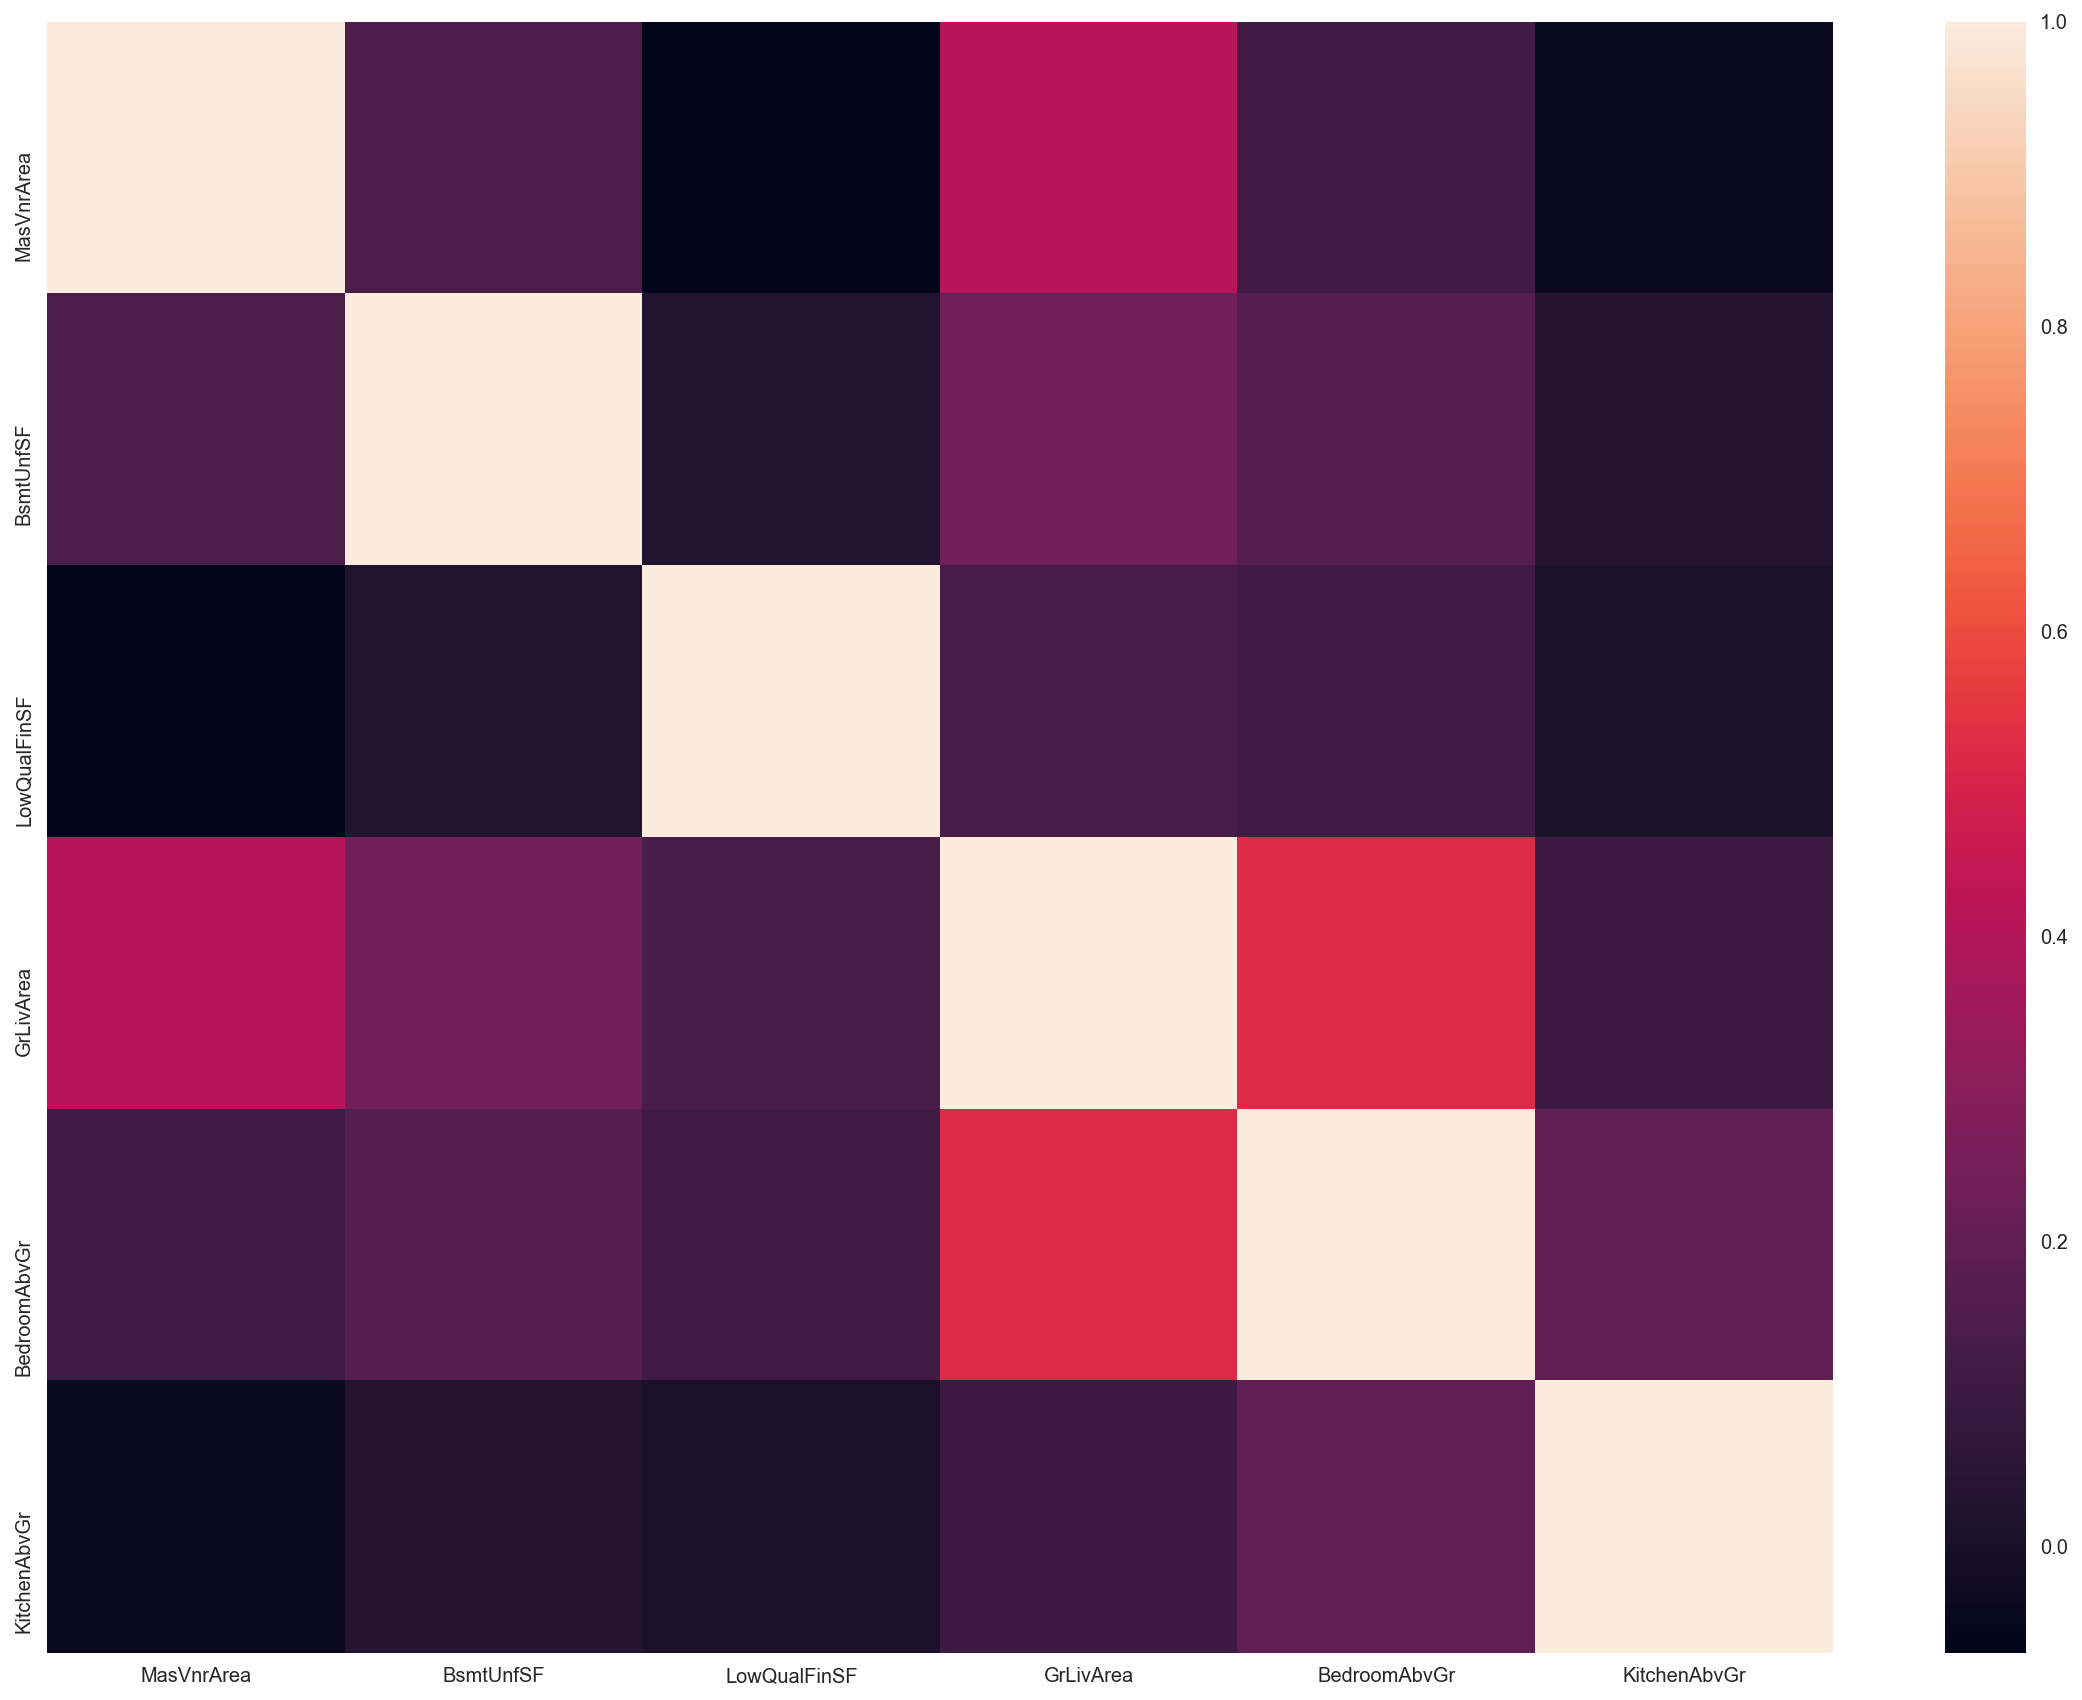

In [48]:
# Filter: Pearson

sns.set(rc={"figure.figsize": (20, 15)})
corr_con = renovable[cont].corr()
sns.heatmap(corr_con)

In [49]:
# Identify correlation > 0.5 (threshold)

pd.set_option('display.max_columns', 50)
corr_con[corr_con >= 0.5]

,MasVnrArea,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr
MasVnrArea,1.0,NaN,NaN,NaN,NaN,NaN
BsmtUnfSF,NaN,1.0,NaN,NaN,NaN,NaN
LowQualFinSF,NaN,NaN,1.0,NaN,NaN,NaN
GrLivArea,NaN,NaN,NaN,1.00000,0.52026,NaN
BedroomAbvGr,NaN,NaN,NaN,0.52026,1.00000,NaN
KitchenAbvGr,NaN,NaN,NaN,NaN,NaN,1.0


In [50]:
renovable.drop('BedroomAbvGr',axis=1,inplace=True)

## CATEGORICAL

In [51]:
# Identify features that are rankings

ranks = pd.Series(['ExterQual','ExterCond','BsmtCond','BsmtFinType1','BsmtFinType2',
         'HeatingQC','KitchenQual','Functional',
         'GarageFinish','GarageQual','GarageCond'])

In [52]:
# Rank each feature with numeric ranking

import re

rank_no = {np.nan:0,'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}

for rank in list(ranks[ranks.str.contains('\w*Cond$|\w*Q\w*')]):
    renovable[rank].replace(rank_no,inplace=True)


bsmt_rank = {np.nan:0,'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1}
func_rank = {np.nan:0,'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1,np.nan:0}
garg_rank = {np.nan:0,'Fin':3,'RFn':2,'Unf':1}

renovable['BsmtFinType1'].replace(bsmt_rank,inplace=True)
renovable['BsmtFinType2'].replace(bsmt_rank,inplace=True)
renovable['Functional'].replace(func_rank,inplace=True)
renovable['GarageFinish'].replace(garg_rank,inplace=True)

In [53]:
# Rank 

for rank in list(ranks):
    rhe = rank_hot_encoder(renovable[rank],prefix=str(rank)+'_',nan=True)
    renovable = renovable.merge(rhe,how='outer',left_index=True, right_index=True)
    renovable = renovable.drop(rank,axis=1)

In [54]:
# Slice rest of the data to binarize

to_bin = []

for col in renovable.columns:
    if renovable[col].dtype == object:
        to_bin.append(col)


In [55]:
# get dummies for categorical features

renovable = renovable.merge(pd.get_dummies(renovable[to_bin],drop_first=True),left_index=True, right_index=True)
renovable.drop(renovable[to_bin],axis=1,inplace=True)

In [56]:
train_data2 = renovable[renovable['YrSold'] < 2010]
test_data2 = renovable[renovable['YrSold'] >= 2010]

X_train = train_data2.drop('var',axis=1)
y_train = train_data2['var']

X_test = test_data2.drop('var',axis=1)
y_test = test_data2['var']

In [57]:
# Feature selection with rfe

from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

rg = Ridge()
selector = RFECV(rg, step=1, cv=10)
selector = selector.fit(X_train, y_train)

print selector.ranking_
print 'R2: ',selector.score(X_test, y_test)

[37 72 51  1 66 73 65  1  1 40 53  1  1  1 85  1 54  1 67 43 42 25 81 33  1
  1 31 48 68 76  1 24 74 83 64 70 69  5 59 78 14 58 13  1  1 79 34 20 23 82
  6 35  1  1  1  1 41 15 16  1 36 75  1 27  1 22 84 26  1  1 50 80  8 19 47
 46  1  1  1 44  1 63  1  1  1 77  1 39 17  1 55  2  1 61  1  1 56  1  4  1
  1 38 32  1 60  1  1  1 62 45  1 57  1  1 10 12 11 30 29 21 49  1 28  3 71
  1  1  1  9 52 18  7]
R2:  0.429318270227


In [58]:
# Feature selection with LassoCV

# select the best alpha with LassoCV

lassoregcv = LassoCV(n_alphas=100, normalize=True, random_state=1)
lassoregcv.fit(X_train, y_train)

    # examine the coefficients
print "coefs:",lassoregcv.coef_

coefs: [ -4895.55050967     -0.              0.         -26865.62917682      0.
      0.             -0.             -0.         -14617.34493906
  -5423.45149691  -4608.95280259 -42203.25946619 -53693.33383542
 -21726.48112211      0.              0.             -0.         -12729.90287261
     -0.             -0.             -0.             -0.              0.
     -0.          -7599.99445454     -0.             -0.              0.
     -0.              0.          -7036.36941134     -0.             -0.
      0.             -0.             -0.             -0.         -10910.04354174
     -0.              0.             -0.             -0.              0.
     -0.              0.              0.             -0.          -1562.26914831
     -0.              0.             -0.         -11644.36734505
  -9991.65557381 -21604.87028714     -0.             -0.             -0.
     -0.             -0.         -15283.24496233  -5477.69437532      0.
     -0.             -0.             -0.    

In [59]:
# Remove columns with 0 lasso_coef

coef = list(lassoregcv.coef_)
new_col = []
for ind,num in enumerate(coef):
    if num != 0.0 or num != -0.0:
        new_col.append(ind)       

newX_train = X_train.iloc[:,new_col]
newy_train = y_train

newX_test = X_test.iloc[:,new_col]
newy_test = y_test

print newX_train.columns

Index([u'MasVnrArea', u'GrLivArea', u'overallqual_4', u'overallqual_5',
       u'overallqual_6', u'overallqual_7', u'overallqual_8', u'overallqual_9',
       u'overallcond_4', u'ExterQual_4', u'BsmtCond_1', u'BsmtFinType1_4',
       u'HeatingQC_3', u'KitchenQual_4', u'KitchenQual_5', u'Functional_3',
       u'GarageFinish_1', u'GarageFinish_2', u'CentralAir_Y'],
      dtype='object')


In [60]:
ridgeregcv = RidgeCV(normalize=False)
ridgeregcv.fit(newX_train, newy_train)

print 'coefficients: ',ridgeregcv.coef_
print 'R2: ',ridgeregcv.score(newX_test, newy_test)

coefficients:  [ -7421.26596377 -28636.6160772  -18928.23151602  -5874.33530735
  -5603.0356576  -39991.14228768 -45464.59848617 -31234.98206296
 -21504.44660766  -7727.23705964 -20753.48335614 -16363.43969767
  -6695.71126409 -10877.03073749 -20619.87702717 -19035.43530006
 -13975.07684222 -10827.20409559 -19755.00851495]
R2:  0.487136755905


<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:left;padding:8px;">

<span style="color:black">

<p>

Around <b>48%</b> of the variance can be explained by:
<br><br>
<li>Masonry veneer area in square feet</li>
<li>Above grade (ground) living area square feet</li>
<li>**Overall Quality</li>
<li>Quality of the material on the exterior</li>
<li>Basement Condition</li>
<li>Basement Finish Type</li>
<li>Heating Quality (threshold: Rank 3 - Average)</li>
<li>Kitchen Quality (threshold: Rank 4,5 - Good,Excellent )</li>
<li>Home functionality </li>
<li>Garage Finish</li>
<li>Central Air-conditioning</li>
<br>
which means that we should focus on the above features.

</p>

</div>

<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:left;padding:8px;">

<span style="color:black">

<p>
<b>Learning Points & Future Improvements</b>
<br><br>
<li>Investigate what features affects the overall quality</li>
<li>Do more EDA, plot more graphs for each feature</li>
<li>Use other train model with different methods to improve predictions</li>
</p>

</div>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [61]:
house_again = pd.concat((fixed,renovable),axis=1)   # Concat both fixed and renovable features together

In [62]:
remove = [col for col in house_again.columns if 'SaleCondition' in col]
house_again.drop(house_again[remove],axis=1,inplace=True)       # remove SaleCondition dummy variables 

In [63]:
house_again['SaleCondition'] = house['SaleCondition']    # Add back original SaleCondition

In [64]:
# Function to identify Abnormal Sale as 1

def abnorm(x):
    if x == 'Abnorml':
        x = 1
    else:
        x = 0
        
    return x

In [65]:
house_again['SaleCondition'] = house_again['SaleCondition'].map(abnorm)  # Apply the function

In [66]:
# check the number of unique values in SaleCondition

house_again['SaleCondition'].value_counts()

0    1298
1      97
Name: SaleCondition, dtype: int64

<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:left;padding:8px;">

<span style="color:black">

<p>

Handling imbalanced classes:
<br>
<br><b>Step 1:</b> Train Test Split
<br><b>Step 2:</b> Oversample the minority using SMOTE / SMOTEENN
<br><b>Step 3:</b> RFE + Fit training data into model (Logistic Regression/SVM/Decision Tree)
<br><b>Step 4:</b> Create confusion matrix (result)
<br><b>Step 5:</b> Calculate and plot ROC curve


</p>

</div>

In [67]:
X = house_again.drop('SaleCondition',axis=1)
y = house_again['SaleCondition']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=2)

In [68]:
y_train.value_counts()   # just to check if it is really stratified

0    908
1     68
Name: SaleCondition, dtype: int64

In [69]:
y_test.value_counts()   # just to check if it is really stratified

0    390
1     29
Name: SaleCondition, dtype: int64

<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:center;padding:8px;">


<b style="font-size:20pt">USING SMOTE</b>
<br>
Smoteen over-samples the minority class only


</div>

In [70]:
from sklearn.metrics import roc_curve, auc

In [71]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2, ratio = 1.0)
X_train_sam, y_train_sam = sm.fit_sample(X_train, y_train)

/Users/joannasyeow/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [72]:
y_train_sam.sum()   # total number of 'abnormal'

908

In [73]:
len(y_train_sam)    # total number of rows

1816

In [74]:
# Logistic Regression with RFE (step 5)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',solver='liblinear')
selector = RFECV(lr, step=5, cv=None)
selector = selector.fit(X_train_sam, y_train_sam)

logreg5_r2 = selector.score(X_test, y_test)

print selector.ranking_
print 'R2: ',logreg5_r2

[ 1  4  1  1  1  1  1  3  4  4  1  5  6  5  1  1  6  9  1  1  7  1 13 15 15
 17 17  1  1  7  1  3  7  1  5 18 16  1 16  1 16 16  1 14  1 16 20  7  1 14
  9 11  1 19  1  1  1 19 22  1  3 12  6 18 24 20 20  2 12  1  1 24 24 21 21
 29 23 23 23 23 21 25  1  2 31 25 21  1  1  2 26  1 32 32  8 32 35  1 35 35
 30  1 30  1  1 29  1  1 34  5  1 28 17 36  1  1  1  1 34  1 34 33 27  1 18
 15  1  1  1 13  1  1 25 26  1 27  1  8  2  1  1 10 20 10  9 13  1  1  1  1
  1 22  1  2  6  9 11  1  3  6 15 13  1  1 19  7  1  1  1  1  1  1 11 17  1
  8 30  1 23 14 19  1  1 19  1 35  1  1  1 26  1  1 28  8 25 32 31 31  1 31
  1  1  1 26  1 28 29  1  1  1  1 32  3  1 28 29 33 10  1  1 35 22 33  1 12
 15 18 36 36 36 12 21  5 27 27 27 11 26 28 29  1 31  1 34  1 34  1  1 33 33
 36  1 30 25 24  1 24 30  4 22  1 22  1  1  1  1 14  4  1 14 10 18  8  1 20
 17 13  9 11 10 12  1]
R2:  0.863961813842


In [75]:
yhat_lr5_sam = selector.predict(X_test)

from sklearn.metrics import confusion_matrix

# Confusion Matrix

confmat = np.array(confusion_matrix(y_test, yhat_lr5_sam, labels=[1,0]))

confusion = pd.DataFrame(confmat, index=['is_abnorm', 'is_not_abnorm'],
                         columns=['predicted_abnorm','predicted_not_abnorm'])
confusion

,predicted_abnorm,predicted_not_abnorm
is_abnorm,10,19
is_not_abnorm,38,352


In [76]:
yhat_lr5_sam_pp = selector.predict_proba(X_test)      # predictions probability

# AUC score
fpr_lr5_sam, tpr_lr5_sam, _ = roc_curve(y_test, yhat_lr5_sam_pp[:,1])
roc_auc_lr5_sam = auc(fpr_lr5_sam, tpr_lr5_sam)     

print 'auc:',roc_auc_lr5_sam

from sklearn.metrics import f1_score

print 'f1-score:',f1_score(y_test,yhat_lr5_sam)

auc: 0.63899204244
f1-score: 0.25974025974


In [77]:
# Logistic Regression with RFE

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',solver='liblinear')
selector = RFECV(lr, step=10, cv=None)
selector = selector.fit(X_train_sam, y_train_sam)

logreg10_r2 = selector.score(X_test, y_test)

print selector.ranking_
print 'R2: ',logreg10_r2

[ 1  1  1  1  1  1  1  1  1  1  1  2  2  2  1  1  4  4  1  1  3  1  5  6  6
  6  6  1  1  3  1  1  3  1  2  8  9  1  9  1  9  9  1  9  1  8  8  3  1  7
  7  7  1  7  1  1  1  2 12  1  1 12  2 12 12 12 12  1  7  1  1  7 10 10 10
 10 11 11 11 11 11 11  1  1 11 11 10  1  1  1 13  1 13 13  3 13 13  1 13 13
 15  1 15  1  1 15  1  1 15  2  1 15 17 17  1  1  1  1 17  1 17 16 16  1 16
 16  1  1  1 16  1  1 16 15  1 14  1  3  1  1  1 14 14  7  8 10  1  1  1  1
  1  9  1  1  2  4  5  1  1  2  4  4  1  1  4  3  1  1  1  1  1  1  5  5  1
  3  5  1  6 12  6  1  1  8  1  6  1  1  1  4  1  1 12  3  5  4  5  5  1 13
  1  1  1  7  1 11  7  1  1  1  1 15  1  1  8  8  9  7  1  1 10 10 10  1 10
 12 13 17 17 17 13 14  1 14 14 14 14 14 15 16  1 16  1 16  1 16  1  1 17 17
 17  1 15 15  6  1 11 12  1  6  1  8  1  1  1  1  8  2  1  9  9  9  3  1  6
  5  5  4  4  8 14  1]
R2:  0.866348448687


In [78]:
yhat_lr10_sam = selector.predict(X_test)

In [79]:
# Confusion Matrix

confmat = np.array(confusion_matrix(y_test, yhat_lr10_sam, labels=[1,0]))

confusion = pd.DataFrame(confmat, index=['is_abnorm', 'is_not_abnorm'],
                         columns=['predicted_abnorm','predicted_not_abnorm'])
confusion

,predicted_abnorm,predicted_not_abnorm
is_abnorm,10,19
is_not_abnorm,37,353


In [80]:
yhat_lr10_sam_pp = selector.predict_proba(X_test)  # Predicition probability

#AUC Score
fpr_lr10_sam, tpr_lr10_sam, _ = roc_curve(y_test, yhat_lr10_sam_pp[:,1])
roc_auc_lr10_sam = auc(fpr_lr10_sam, tpr_lr10_sam)
print 'auc:',roc_auc_lr10_sam

print 'f1-score:',f1_score(y_test,yhat_lr10_sam)

auc: 0.631476569408
f1-score: 0.263157894737


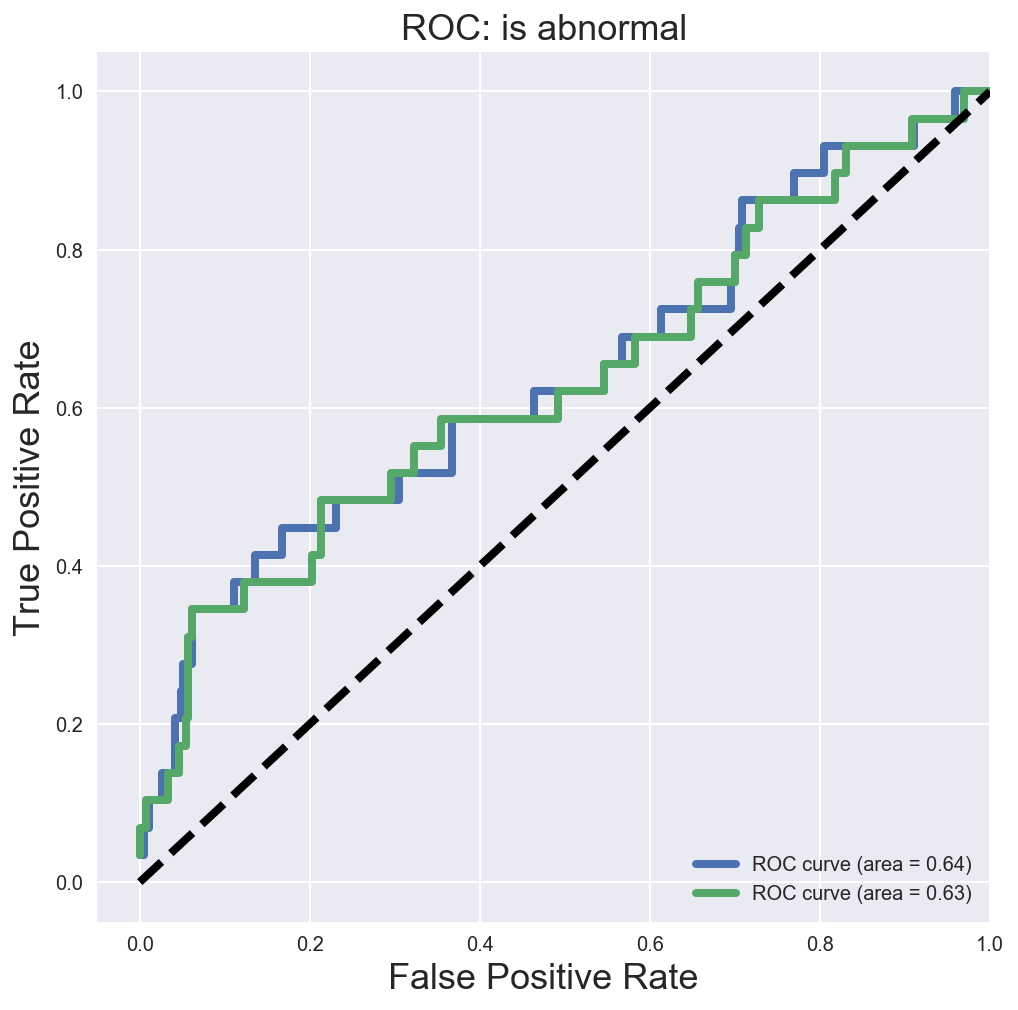

In [81]:
plt.figure(figsize=[8,8])

plt.plot(fpr_lr5_sam, tpr_lr5_sam, label='ROC curve (area = %0.2f)' % roc_auc_lr5_sam, linewidth=4)
plt.plot(fpr_lr10_sam, tpr_lr10_sam, label='ROC curve (area = %0.2f)' % roc_auc_lr10_sam, linewidth=4)
#plt.plot(fpr_rf_sam, tpr_rf_sam, label='ROC curve (area = %0.2f)' % roc_auc_rf_sam, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC: is abnormal', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [82]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score

AUC : 0.672900088417
f1-score: 0.170347003155


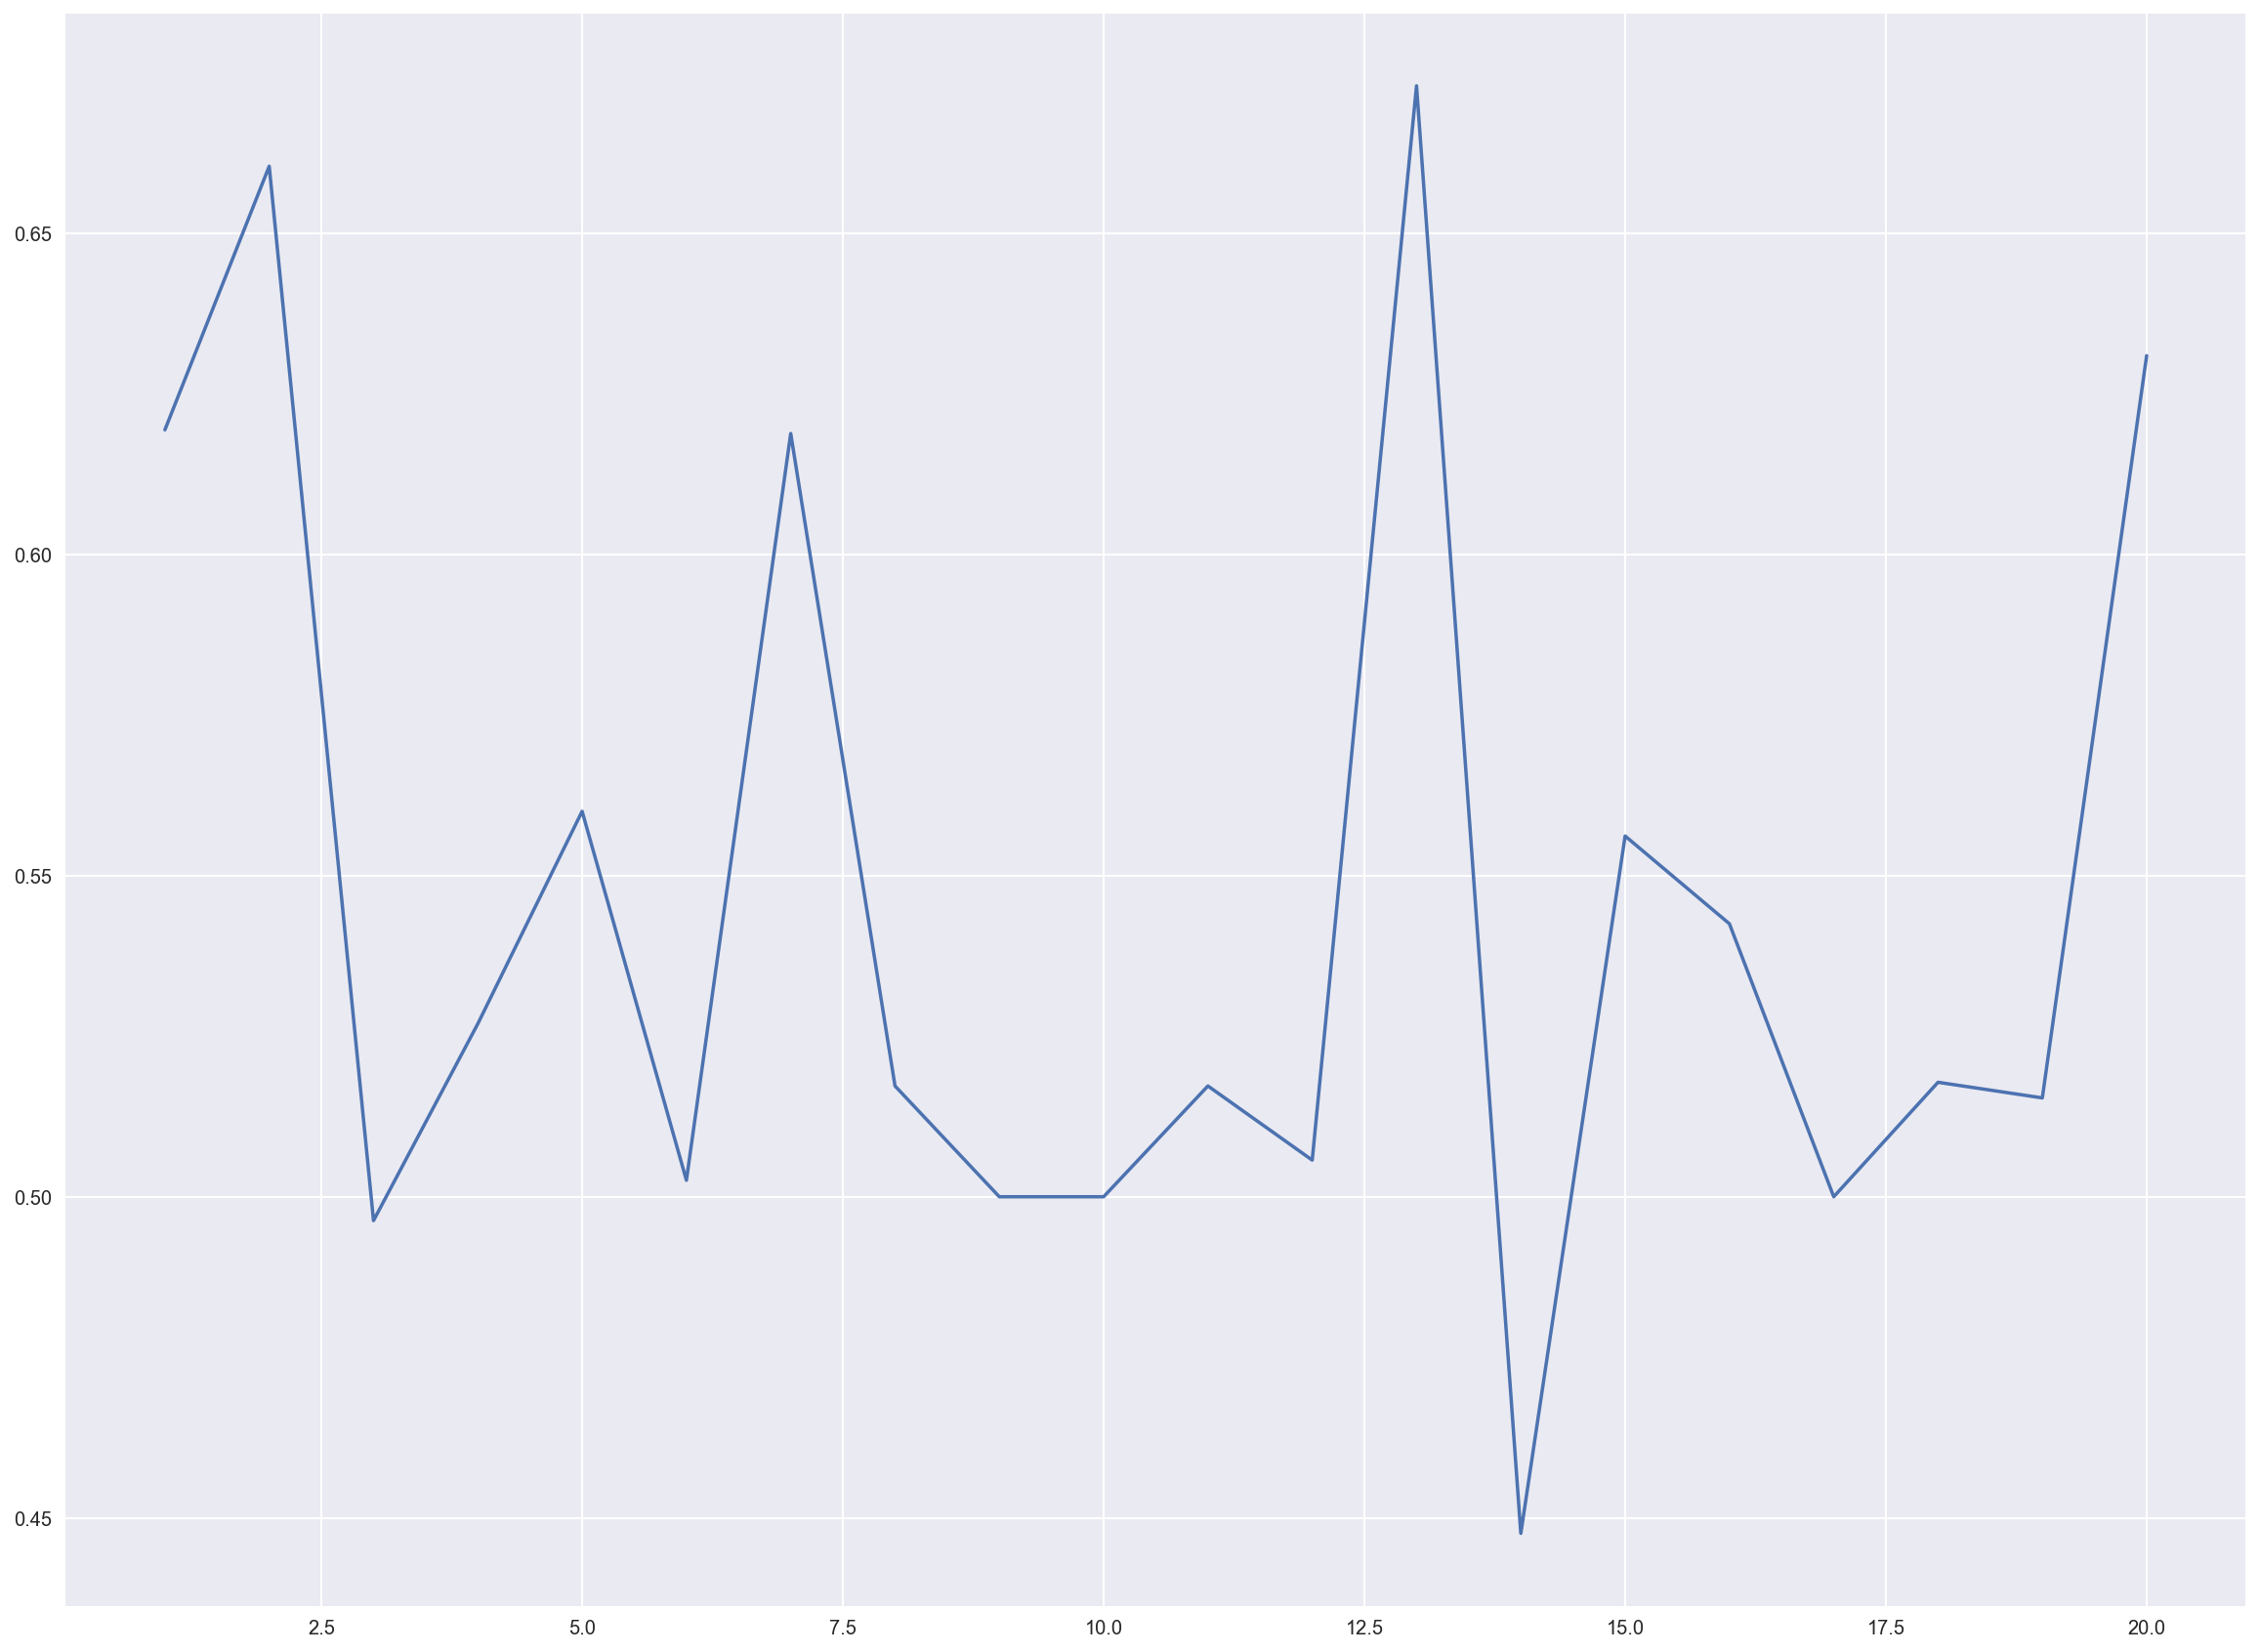

In [83]:
# Linear SVM

auc_lin = []

for c in range(1,21):
    svm_linear = LinearSVC(C=c)
    svm_lin_model = svm_linear.fit(X_train_sam,y_train_sam)
    yhat_svm_lin_sam = svm_lin_model.predict(X_test)
    auc_lin.append(roc_auc_score(y_test, yhat_svm_lin_sam))
    
plt.plot(range(1,21),auc_lin)

max_auc_lin = max(auc_lin)

print 'AUC :', max(auc_lin)
print 'f1-score:',f1_score(y_test,yhat_svm_lin_sam)

In [84]:
from sklearn.tree import DecisionTreeClassifier

In [85]:
# Decision Tree

max_depths = [1,2,3,None]

for depth in max_depths:
    
    dtc = DecisionTreeClassifier(max_depth=depth)
    dtc.fit(X_train_sam,y_train_sam)
    
    dtc_pred = dtc.predict(X_test)
    dtc_pp = dtc.predict_proba(X_test)  # Predicition probability

    #AUC Score
    fpr_dtc, tpr_dtc, _ = roc_curve(y_test, dtc_pp[:,1])
    dtc_auc = auc(fpr_dtc, tpr_dtc)
    
    print depth
    print 'auc:',dtc_auc
    print 'f1-score:',f1_score(y_test,dtc_pred)

1
auc: 0.598320070734
f1-score: 0.307692307692
2
auc: 0.648452696729
f1-score: 0.170403587444
3
auc: 0.607648099027
f1-score: 0.136752136752
None
auc: 0.549027409372
f1-score: 0.15873015873


In [86]:
# Fit model at max depth 2

print 'At max depth 2'

best_dtc = DecisionTreeClassifier(max_depth=2)
best_dtc.fit(X_train_sam,y_train_sam)

# AUC

dtc_predictions = best_dtc.predict(X_test)
dtc_auc = roc_auc_score(y_test, dtc_predictions)
    
    
# Confusion Matrix

confmat = np.array(confusion_matrix(y_test, dtc_predictions, labels=[1,0]))

confusion = pd.DataFrame(confmat, index=['is_abnorm', 'is_not_abnorm'],
                         columns=['predicted_abnorm','predicted_not_abnorm'])
confusion

At max depth 2


,predicted_abnorm,predicted_not_abnorm
is_abnorm,19,10
is_not_abnorm,175,215


<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:center;padding:8px;">


<b style="font-size:20pt">USING SMOTEENN</b>
<br>
Smoteen over-samples the minority class and under-sample the majority class


</div>

In [87]:
from imblearn.combine import SMOTEENN

smenn = SMOTEENN(random_state=2)
X_train_samn, y_train_samn = smenn.fit_sample(X_train, y_train)

In [88]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,BsmtFinSF2,TotalBsmtSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,YrSold,SalePrice,MSZoning_C (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,...,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr
231,-0.130345,0.173649,-0.192776,-0.295876,-0.734671,0.810185,-0.826333,-0.246948,-0.985933,-0.991597,-0.757332,1.483848,-0.368712,-0.119056,-0.275417,-0.089724,2010,113000,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1086,-0.619138,0.842901,-0.193762,-0.295876,-0.328431,-0.771948,-0.826333,-0.246948,-0.985933,0.329585,-0.757332,-0.680388,3.097429,-0.119056,1.946143,-0.089724,2007,144000,0,0,1,0,0,1,1,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1132,3.291209,0.973841,-0.008131,-0.295876,-0.186247,0.800999,1.094892,-0.246948,0.823773,0.329585,-0.757332,0.463565,-0.368712,-0.119056,-0.275417,-0.089724,2009,95000,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1
488,-0.863535,0.435530,-0.157404,0.760861,-0.443532,-0.771948,1.094892,-0.246948,-0.985933,0.329585,-0.757332,-0.680388,-0.368712,-0.119056,-0.275417,-0.089724,2006,129900,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1
82,0.602845,-2.023244,-0.213566,-0.295876,-1.526838,0.766555,-0.826333,-0.246948,0.823773,0.329585,0.189658,0.432648,-0.368712,-0.119056,-0.275417,1.290171,2009,168500,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1


In [90]:
print float(y_train_samn.sum()) / float(len(y_train_samn))   # number of 'abnormal'

492

In [92]:
# Logistic Regression with rfe

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',solver='liblinear')
selector = RFECV(lr, step=5, cv=None)
selector = selector.fit(X_train_samn, y_train_samn)

logreg5_rfe_enn = selector.score(X_test, y_test)

print selector.ranking_
print 'R2: ',logreg5_rfe_enn


[43  2  4  1  5  1  1  3  4  1  3  8  2  3  2  1  7  7  1 10  1 13 13 13  4
 13 10 14 14 14  8  5 16 16 16 18 16  1 18 17 17 17  1 17 18 20  1  6  1  1
 22  1  1 23 22  1 22 21 21  1  3 19 15 15 12 24  1 24 24  1  1 26 26 26 23
 24 25 27 27 27 28 28  1 28 29 29 29 30 29  1 25 13 12 35 33 33 36  1  1  1
 34  1 31  4  1 32  1 38 39 39  6 39  1 37  2 20  1 42 40  1 40 41 41  1 41
  1  1 36  1 36  1  5 33 32 34  1 37 41  1  1  1 42 42 42 43 43 43  1 38  1
 38  6  1  4  7  7  8 28 14 18 10 15 10  1  9 21  1 24 10 11  1 11 27 27  1
 29  7  2  8 28 25  1 14  9 30  1  1 31  1 30  1  1 30 19 11 11 11  1  1 16
 12 12  1 25 25 32 32  1  6  1 32 40  1  1 31 23 23 23 30  1 33 34 34  6 34
 33 31 37 37 37 21 41  1 20 22 40 35 35 35 36  1 39  3 36 35 22  1  1 20 38
 39 38 20 42 43 21 15 15  5 17 40 31  1  1  1  1  1  5  1 26 19 19  1 26 19
 12 18  9  9  9  8  1]
R2:  0.804295942721


In [93]:
yhat_lr5_samn = selector.predict(X_test)

# Confusion Matrix

confmat = np.array(confusion_matrix(y_test, yhat_lr5_samn, labels=[1,0]))

confusion = pd.DataFrame(confmat, index=['is_abnorm', 'is_not_abnorm'],
                         columns=['predicted_abnorm','predicted_not_abnorm'])
confusion

,predicted_abnorm,predicted_not_abnorm
is_abnorm,13,16
is_not_abnorm,66,324


In [94]:
yhat_lr5_samn_pp = selector.predict_proba(X_test)   # Prediction probability

#AUC score
fpr_lr5_samn, tpr_lr5_samn, _ = roc_curve(y_test, yhat_lr5_samn_pp[:,1])
roc_auc_lr5_samn = auc(fpr_lr5_samn, tpr_lr5_samn)

print 'auc:',roc_auc_lr5_samn

# f1-score
print 'f1-score:',f1_score(y_test,yhat_lr5_samn)

auc: 0.66940760389
f1-score: 0.240740740741


In [95]:
# Logistic Regression with rfe

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',solver='liblinear')
selector = RFECV(lr, step=10, cv=None)
selector = selector.fit(X_train_samn, y_train_samn)

logreg10_rfe_enn = selector.score(X_test, y_test)

print selector.ranking_
print 'R2: ',logreg10_rfe_enn

[21  1  3  1  2  1  1  1  2  1  1  4  1  3  1  1  3  3  1  4  1  4  4  4  3
  6  6  6  5  7  7  2  7  7  7  7  7  1  8  8  8  8  1  9  8  9  1  2  1  1
 10  1  1 11 11  1 11 11 11  1  1 10 10  8  8  8  1  8  6  1  1  5  5  5 12
  5  3  5 14  7 13 12  1 17 12 12 15 15 15  1 15 15 15 15 15 12 16  1  1  1
 17  1 17  1  1 17  1 17 17 17  2 14  1 19  1 19  1 19 19  1 20 20 20  1 20
  1  1 20  1 18  1  3 18 18 18  1 20 19  1  1  1 14 13 13 21 21 21  1 21  1
 21  2  1  2  3  3 21 21 13 10 10  5  4  1 11 11  1  4  4  6  1  9  9 11  1
  9  4  1  6  6 10  1 15 15  7  1  1  6  1 10  1  1  6  5  9 10 10  1  1 10
  5  9  1  9  9  9 12  1  2  1 12 14  1  1 14 14 14 14 16  1 17 17 17  2 19
 13 19 19 20 20 20 20  1 19 19 16 16 16 16 16  1 16  1 18 18 18  1  1 18 16
 14 16 13 21 21 13 13 13  3 12 18 12  1  1  1  1  1  2  1 11 11  8  1  4  5
  6  7 12 13 14 18  1]
R2:  0.801909307876


In [96]:
# Confusion Matrix

yhat_lr10_samn = selector.predict(X_test)

confmat = np.array(confusion_matrix(y_test, yhat_lr10_samn, labels=[1,0]))

confusion = pd.DataFrame(confmat, index=['is_abnorm', 'is_not_abnorm'],
                         columns=['predicted_abnorm','predicted_not_abnorm'])
confusion

,predicted_abnorm,predicted_not_abnorm
is_abnorm,12,17
is_not_abnorm,66,324


In [97]:
yhat_lr10_samn_pp = selector.predict_proba(X_test)   # Prediction probability

#AUC score
fpr_lr10_samn, tpr_lr10_samn, _ = roc_curve(y_test, yhat_lr10_samn_pp[:,1])
roc_auc_lr10_samn = auc(fpr_lr10_samn, tpr_lr10_samn)
print 'auc:',roc_auc_lr10_samn

# f1-score
print 'f1-score:',f1_score(y_test,yhat_lr10_samn)

auc: 0.676304155615
f1-score: 0.224299065421


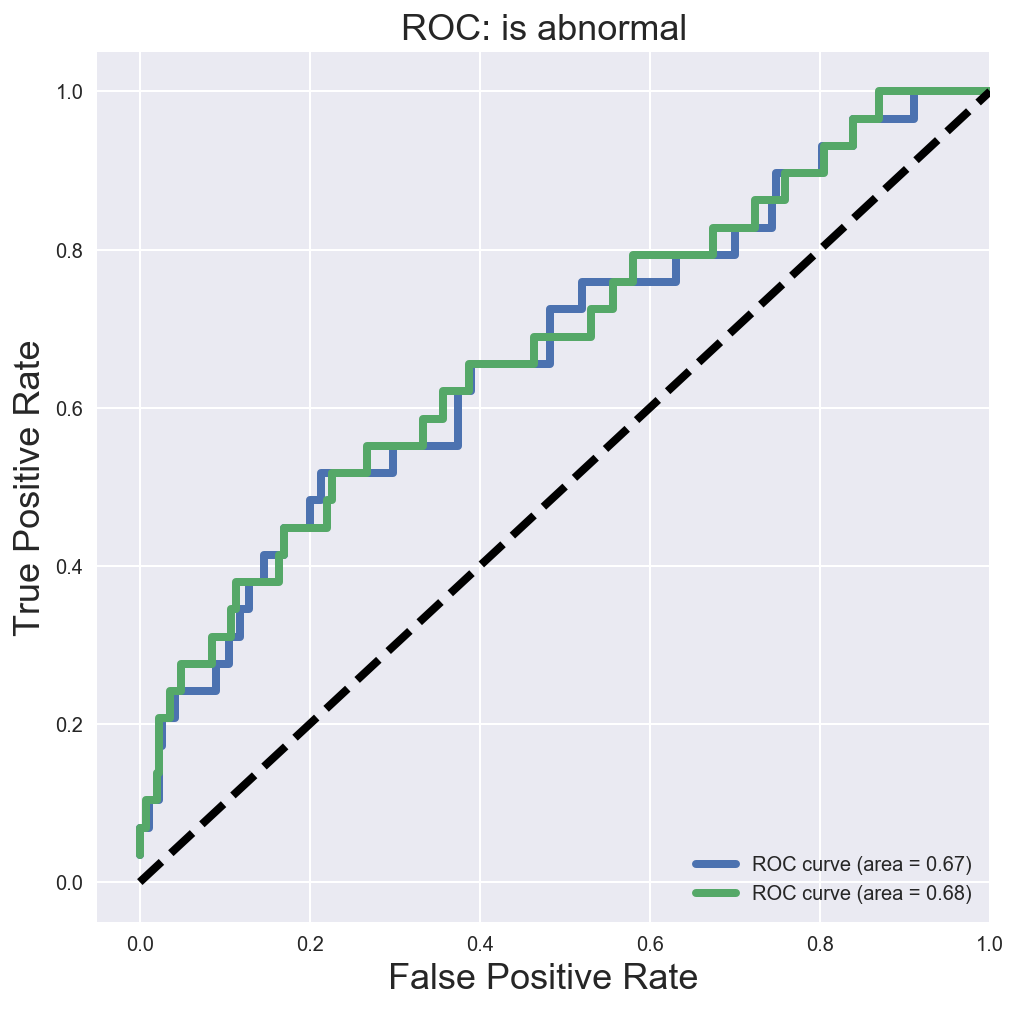

In [98]:
plt.figure(figsize=[8,8])

plt.plot(fpr_lr5_samn, tpr_lr5_samn, label='ROC curve (area = %0.2f)' % roc_auc_lr5_samn, linewidth=4)
plt.plot(fpr_lr10_samn, tpr_lr10_samn, label='ROC curve (area = %0.2f)' % roc_auc_lr10_samn, linewidth=4)
#plt.plot(fpr_rf_samn, tpr_rf_samn, label='ROC curve (area = %0.2f)' % roc_auc_rf_samn, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC: is abnormal', fontsize=18)
plt.legend(loc="lower right")
plt.show()

AUC : 0.705791335102
f1-score: 0.256


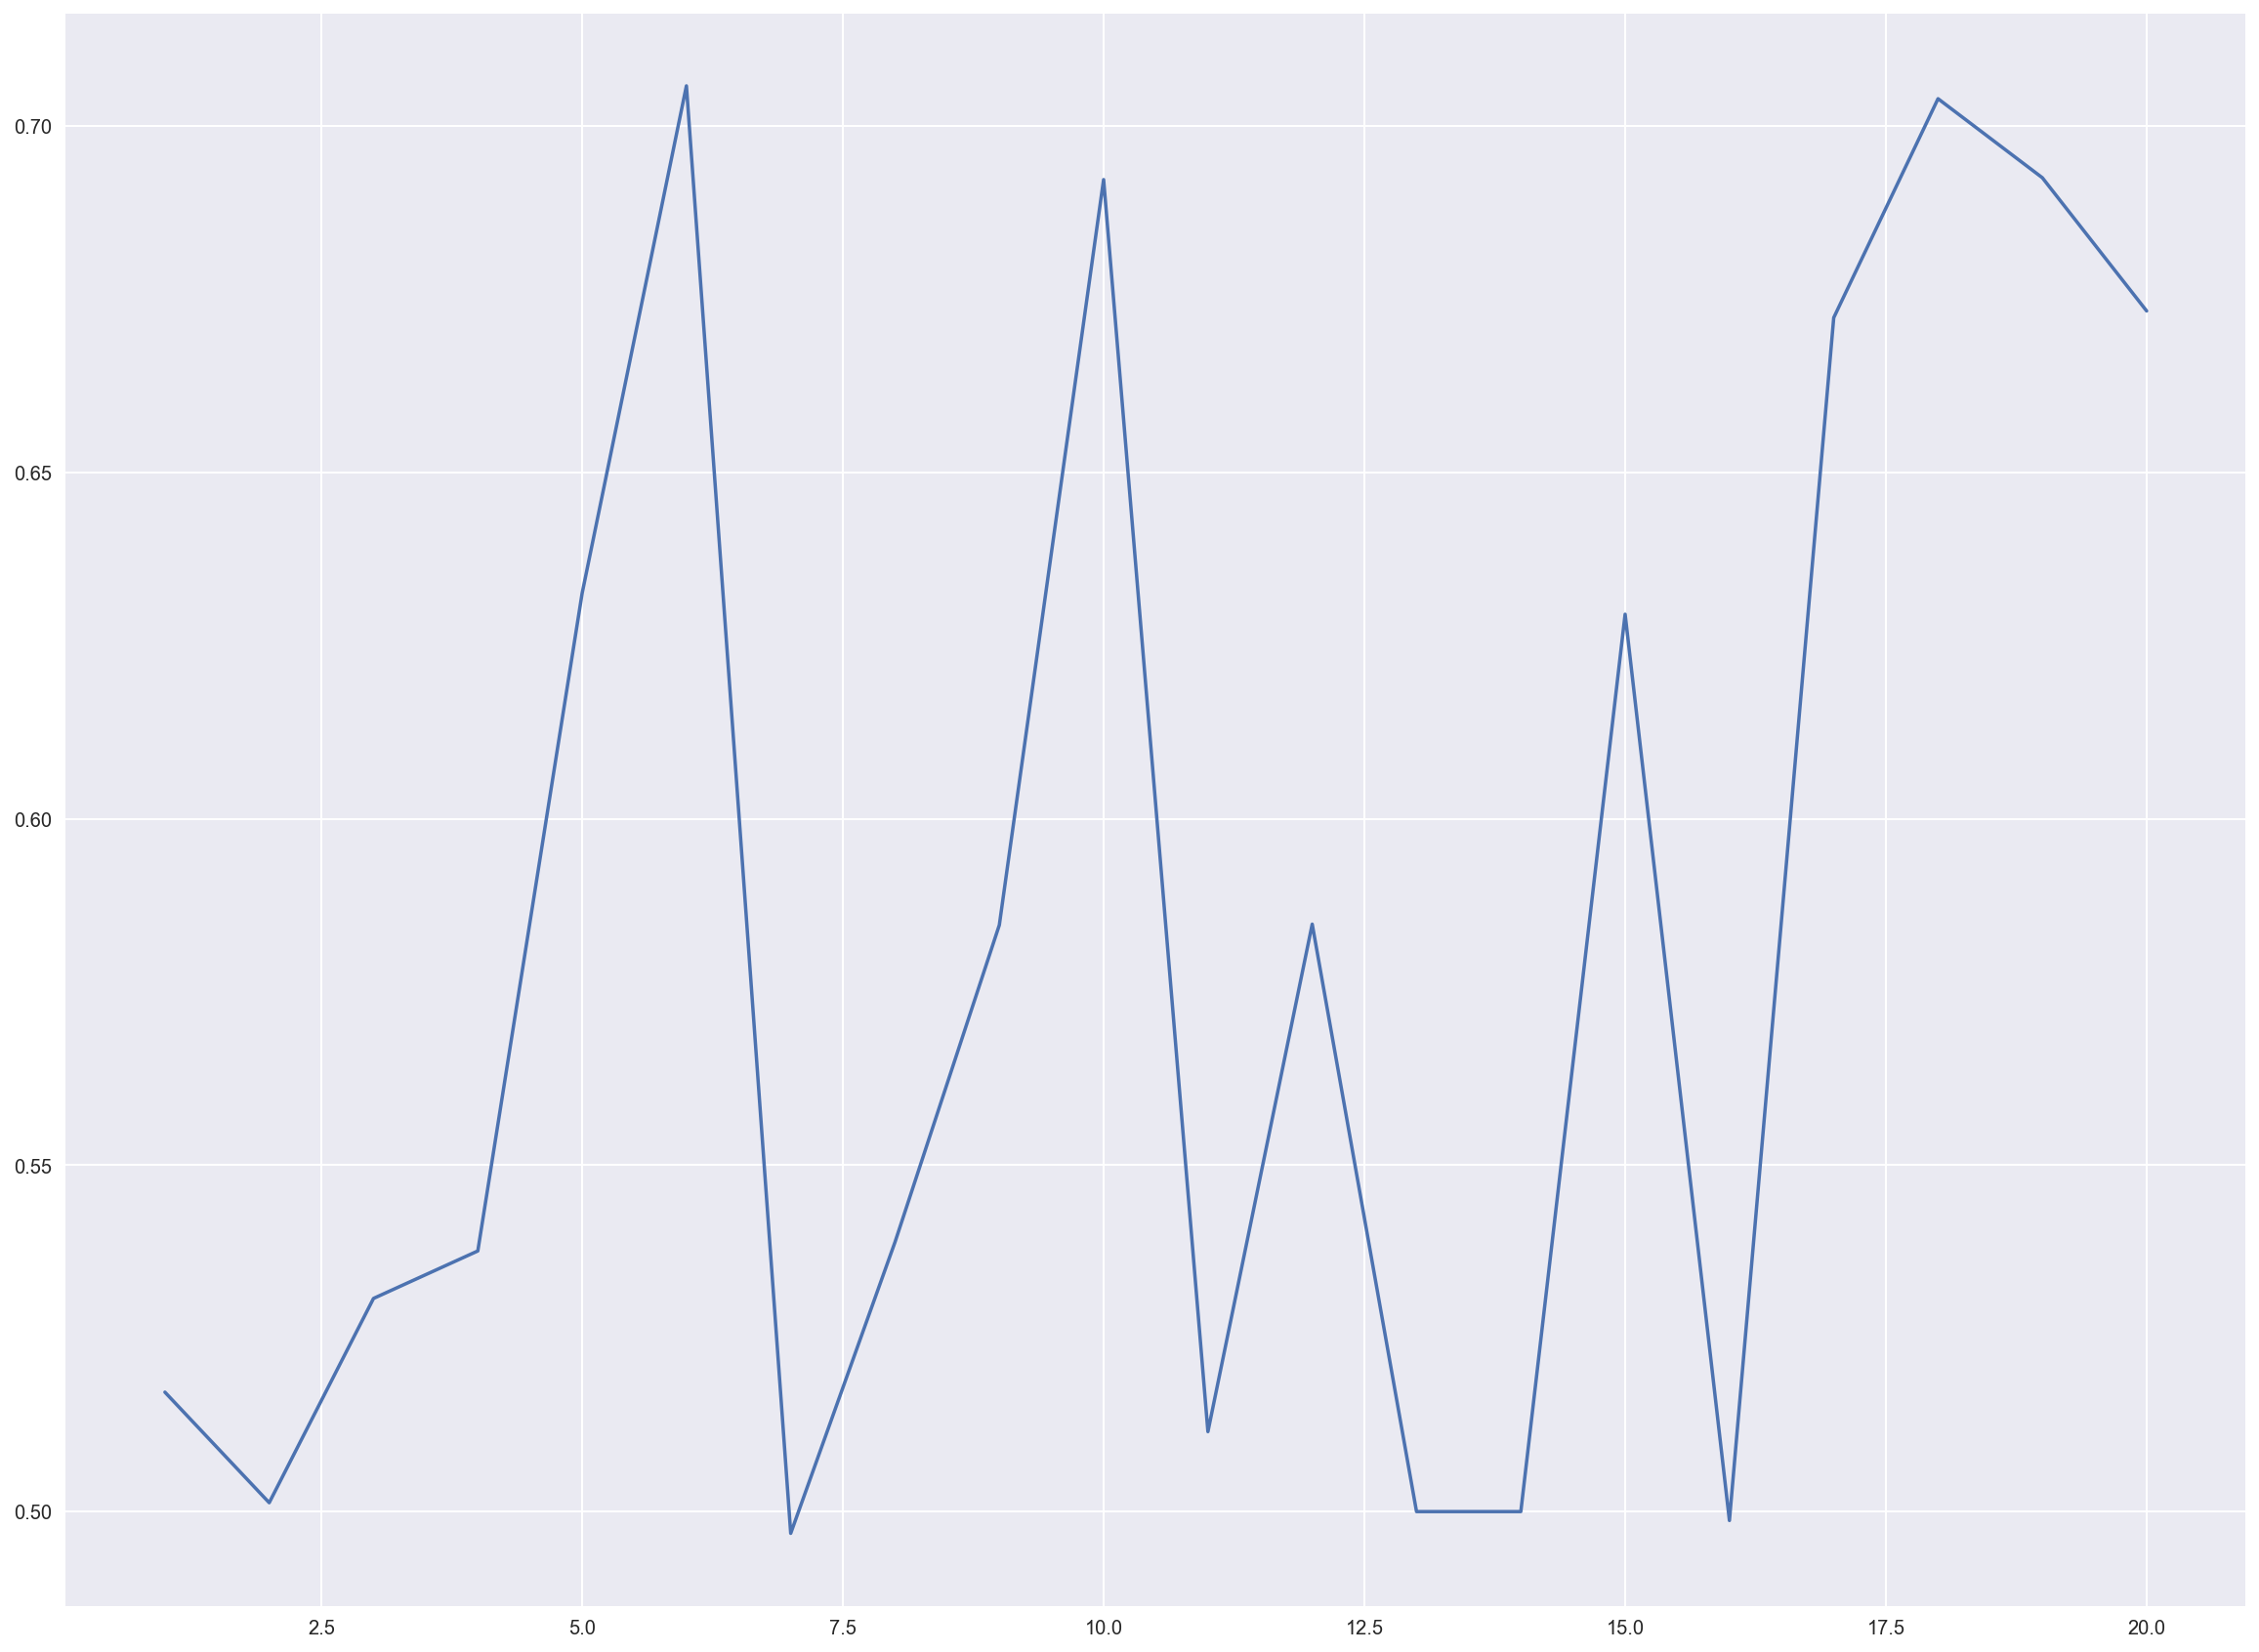

In [99]:
# Linear SVM

auc_lin_enn = []

for c in range(1,21):
    svm_linear_enn = LinearSVC(C=c)
    svm_lin_model_enn = svm_linear_enn.fit(X_train_samn,y_train_samn)
    yhat_svm_lin_samn = svm_lin_model_enn.predict(X_test)
    auc_lin_enn.append(roc_auc_score(y_test, yhat_svm_lin_samn))
    
plt.plot(range(1,21),auc_lin_enn)

max_auc_lin_enn = max(auc_lin_enn)

print 'AUC :', max(auc_lin_enn)
print 'f1-score:',f1_score(y_test,yhat_svm_lin_samn)

In [100]:
# Decision Tree

max_depths = [1,2,3,None]

for depth in max_depths:
    
    dtc_enn = DecisionTreeClassifier(max_depth=depth)
    dtc_enn.fit(X_train_samn,y_train_samn)
    
    dtc_pred_enn = dtc_enn.predict(X_test)
    dtc_pp_enn = dtc_enn.predict_proba(X_test)  # Predicition probability

    #AUC Score
    fpr_dtc_enn, tpr_dtc_enn, _ = roc_curve(y_test, dtc_pp_enn[:,1])
    dtc_auc_enn = auc(fpr_dtc_enn, tpr_dtc_enn)
    
    print depth
    print 'auc:',dtc_auc_enn
    print 'f1-score:',f1_score(y_test,dtc_pred_enn)

1
auc: 0.598320070734
f1-score: 0.307692307692
2
auc: 0.66534040672
f1-score: 0.179372197309
3
auc: 0.620733863837
f1-score: 0.171428571429
None
auc: 0.582228116711
f1-score: 0.212121212121


In [101]:
# Fit model at max depth 2

print 'At max depth 2'

best_dtc_enn = DecisionTreeClassifier(max_depth=2)
best_dtc_enn.fit(X_train_samn,y_train_samn)

dtc_predictions_enn = best_dtc_enn.predict(X_test)

dtc_auc_enn = roc_auc_score(y_test, dtc_predictions_enn)
    
# Confusion Matrix
    
confmat = np.array(confusion_matrix(y_test, dtc_predictions_enn, labels=[1,0]))

confusion = pd.DataFrame(confmat, index=['is_abnorm', 'is_not_abnorm'],
                         columns=['predicted_abnorm','predicted_not_abnorm'])
confusion

At max depth 2


,predicted_abnorm,predicted_not_abnorm
is_abnorm,20,9
is_not_abnorm,174,216


<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:center;padding:8px;">


<b>IN SUMMARY</b>


</div>

In [102]:
index = ['LR_Step_5','LR_Step_10','Linear_SVM','Decision_Tree']
columns = ['AUC','F1 Score']
smote_data = [
[roc_auc_lr5_sam,f1_score(y_test,yhat_lr5_sam)],
[roc_auc_lr10_sam,f1_score(y_test,yhat_lr10_sam)],
[max_auc_lin,f1_score(y_test,yhat_svm_lin_sam)],
[dtc_auc,f1_score(y_test,dtc_predictions)]
]

smote_df = pd.DataFrame(smote_data,index=index,columns=columns)
smote_df

,AUC,F1 Score
LR_Step_5,0.638992,0.259740
LR_Step_10,0.631477,0.263158
Linear_SVM,0.672900,0.170347
Decision_Tree,0.603227,0.170404


In [106]:
index = ['LR_Step_5','LR_Step_10','Linear_SVM','Decision_Tree']
columns = ['AUC','F1 Score']
smoteenn = [[roc_auc_lr5_samn,f1_score(y_test,yhat_lr5_samn)],
[roc_auc_lr10_samn,f1_score(y_test,yhat_lr10_samn)],
[max_auc_lin_enn,f1_score(y_test,yhat_svm_lin_samn)],
[dtc_auc_enn,f1_score(y_test, dtc_predictions_enn)]
]

smoteenn_df = pd.DataFrame(smoteenn,index=index,columns=columns)
smoteenn_df

,AUC,F1 Score
LR_Step_5,0.669408,0.240741
LR_Step_10,0.676304,0.224299
Linear_SVM,0.705791,0.256000
Decision_Tree,0.621751,0.179372


<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:left;padding:8px;">

<span style="color:black">

<p>
<b>Best Model:</b>
<br>
<br>
1. Use SMOTEENN to oversample the minority class
<br>
2. Linear SVM
<br>
3. Estimated accuracy of 70%

</p>

</div>

<div style="width:900px;background:#F9EECF;border:1px solid black;text-align:left;padding:8px;">

<span style="color:black">

<p>
<b>Learning Points & Future Improvements</b>
<br><br>
<li>Use other methods to work on imbalanced data (CostSensitiveClassifier, etc)</li>
<li>Do more EDA, plot more graphs for each feature</li>
<li>Use other train model with different methods to improve predictions</li>
<li>Get a better laptop or use AWS to try more complex models/do GridSearch</li>
</p>

</div>